In [1]:
#!pip install tensorflow
#!pip install fasttext
#!pip install mlxtend
#import nltk
#nltk.download("all")

In [2]:
#loading libraries
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import scipy.sparse as sp
from scipy.stats import uniform, randint

#loading visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
from statistics import mean, stdev
import plotly.graph_objects as go

#loading nltk libraries
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from unicodedata import normalize

#loading scikit libraries
import sklearn
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score, make_scorer, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

#loading gensim libraries
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import FastText

import time
import warnings
warnings.filterwarnings('ignore')

## Loading Training and testing Data Files

In [3]:
#loading the training and testing file on a dataframe
train_data = pd.read_csv("C:/Users/ritac/Documents/Datasets/4a-english/4A-English/SemEval2017-task4-dev.subtask-A.english.INPUT.txt", 
                        sep="	", header=None, usecols=[1,2], names=["sentiments", "tweets"])

SemEval_test_data = pd.read_csv("C:/Users/ritac/Documents/Datasets/SemEval2017-task4-test.subtask-A.english.txt", 
                           sep="	", header=None, usecols=[1,2], names=["sentiments", "tweets"] )

### Train Data Description and shape

In [4]:
# getting the total number of sentiments for each class
train_data.sentiments.value_counts()

neutral     10342
positive     7059
negative     3231
Name: sentiments, dtype: int64

In [5]:
# extracting first five rows
train_data.head()

sentiments                                             tweets
0    neutral  Picturehouse's, Pink Floyd's, 'Roger Waters: T...
1    neutral  Order Go Set a Watchman in store or through ou...
2   negative  If these runway renovations at the airport pre...
3    neutral  If you could ask an onstage interview question...
4   positive  A portion of book sales from our Harper Lee/Go...

In [6]:
#printing Data Shape
train_data.shape

(20632, 2)

### Test Data Description and shape

In [7]:
# counting the total number for each sentiment
SemEval_test_data.sentiments.value_counts()

neutral     5743
negative    3811
positive    2352
Name: sentiments, dtype: int64

In [8]:
# checking first five Rows of the data
SemEval_test_data.head()

sentiments                                             tweets
0    neutral  #ArianaGrande Ari By Ariana Grande 80% Full ht...
1   positive  Ariana Grande KIIS FM Yours Truly CD listening...
2   positive  Ariana Grande White House Easter Egg Roll in W...
3   positive  #CD #Musics Ariana Grande Sweet Like Candy 3.4...
4    neutral  SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...

In [9]:
# Printing Data Shape
SemEval_test_data.shape

(11906, 2)

## Cleaning Training Data

In [10]:
#getting a description of the data before cleaning
train_data.describe(include="object")

sentiments                                             tweets
count       20632                                              20632
unique          3                                              20552
top       neutral  Tomorrow Seth Rollins's WWE title reign will s...
freq        10342                                                  2

In [11]:
# checking for empty rows
train_data.isna().sum()

sentiments    0
tweets        0
dtype: int64

In [12]:
#checking for duplicates
train_data.duplicated(subset="tweets").sum()

80

In [13]:
# removing duplicates from the training data
train_data = train_data.drop_duplicates(subset="tweets")

In [14]:
# getting a description of data after cleaning
train_data.describe(include="object")

sentiments                                             tweets
count       20552                                              20552
unique          3                                              20552
top       neutral  Picturehouse's, Pink Floyd's, 'Roger Waters: T...
freq        10299                                                  1

## Cleaning Test Data

In [15]:
#getting a description of the data before cleaning
SemEval_test_data.describe(include="object")

sentiments                                             tweets
count       11906                                              11906
unique          3                                              11906
top       neutral  #ArianaGrande Ari By Ariana Grande 80% Full ht...
freq         5743                                                  1

In [16]:
# checking for empty rows
SemEval_test_data.isna().sum()

sentiments    0
tweets        0
dtype: int64

In [17]:
#checking for duplicates
SemEval_test_data.duplicated(subset="tweets").sum()

0

In [18]:
# getting a description of data after cleaning
SemEval_test_data.describe(include="object")

sentiments                                             tweets
count       11906                                              11906
unique          3                                              11906
top       neutral  #ArianaGrande Ari By Ariana Grande 80% Full ht...
freq         5743                                                  1

## Data Preprocessing Function

In [19]:
#function for preprocessing tweets
def preprocess_text(data):
    preprocessed_tweets = []
    sentiment = []

    for index, tweet in data.iterrows():
        # Remove hashtags and mentions
        clean_tweets = re.sub(r"#\S+|@\S+", "", tweet.tweets)
        # Replace newlines with a space
        clean_tweets = clean_tweets.replace("\n", " ")
        # Remove URLs
        clean_tweets = re.sub(r"http\S+|www\S+|https\S+", "", clean_tweets)
        # Remove punctuation, symbols, and reduce whitespace
        clean_tweets = re.sub(r"[^\w\s]", " ", clean_tweets)
        clean_tweets = re.sub(r"\s+", " ", clean_tweets).strip()
        # Remove words with digits
        clean_tweets = re.sub(r"\b\w*\d\w*\b", "", clean_tweets)
        # Reduce repeated characters
        clean_tweets = re.sub(r'(.)\1+', r'\1\1', clean_tweets)
        
        # Convert to lower case
        clean_tweets = clean_tweets.lower()
        
        # Tokenize texts
        tokens = word_tokenize(clean_tweets)
        
        # Part-of-speech tagging
        tagged_tokens = pos_tag(tokens)

        # Initialize stop words
        stop_words = set(stopwords.words("english"))
        
        # Filter tokens based on POS tags and stop words
        # check if words with specific tags(Noun(N), adjective(J), verb(v), Adverbs(R)) is in tagged tokens and
        # not in stop words. select word and add to the selected tokens list
        selected_tokens = [word for word, pos in tagged_tokens if word not in stop_words and 
                           (pos.startswith('N') or pos.startswith('J') or pos.startswith('V') or pos.startswith('R'))]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in selected_tokens]
        
        # Join back tokens
        preprocessed_tweet = " ".join(lemmatized_tokens)
        
        # Attach sentiment and preprocessed tweet to designated lists
        sentiment.append(tweet.sentiments)
        preprocessed_tweets.append(preprocessed_tweet)

    # Create a new column in the dataframe called 'clean_tweets'
    data['clean_tweets'] = preprocessed_tweets

    # Function output
    return data

## Preprocess Train Data

In [20]:
# preprocessing the train data and assigning the cleaned tweets 
#to a new colum on the dataframe called clean tweets
clean_train_data = preprocess_text(train_data)

# print message
print("completed")

completed


In [21]:
# preprocessed tweets
clean_train_data.head()

sentiments                                             tweets  \
0    neutral  Picturehouse's, Pink Floyd's, 'Roger Waters: T...   
1    neutral  Order Go Set a Watchman in store or through ou...   
2   negative  If these runway renovations at the airport pre...   
3    neutral  If you could ask an onstage interview question...   
4   positive  A portion of book sales from our Harper Lee/Go...   

                                        clean_tweets  
0  picturehouse pink floyd roger water wall openi...  
1  order go set watchman store website tuesday ge...  
2  runway renovation airport prevent seeing taylo...  
3   ask onstage interview question miss usa tomorrow  
4  portion book sale harper lee go set watchman r...

In [22]:
# create a new dataframe df_train and df_test that contains only the columns "sentiments" and "clean_tweets" 
# from the clean_train_data and clean_test_data dataframes.

df_train = clean_train_data[["sentiments", "clean_tweets"]]
df_train.head()

sentiments                                       clean_tweets
0    neutral  picturehouse pink floyd roger water wall openi...
1    neutral  order go set watchman store website tuesday ge...
2   negative  runway renovation airport prevent seeing taylo...
3    neutral   ask onstage interview question miss usa tomorrow
4   positive  portion book sale harper lee go set watchman r...

## Preprocess Text Data

In [23]:
# preprocessing the train data and assigning the cleaned tweets 
#to a new colum on the dataframe called clean tweets
clean_test_data = preprocess_text(SemEval_test_data)

# print message
print("completed")

completed


In [24]:
# preprocessed tweets
clean_test_data.head()

sentiments                                             tweets  \
0    neutral  #ArianaGrande Ari By Ariana Grande 80% Full ht...   
1   positive  Ariana Grande KIIS FM Yours Truly CD listening...   
2   positive  Ariana Grande White House Easter Egg Roll in W...   
3   positive  #CD #Musics Ariana Grande Sweet Like Candy 3.4...   
4    neutral  SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...   

                                        clean_tweets  
0                             ari ariana grande full  
1  ariana grande kiis fm truly cd listening party...  
2  ariana grande white house easter egg roll wash...  
3  ariana grande sweet candy oz ml sealed box aut...  
4                                          side side

In [25]:
# create a new dataframe df_train and df_test that contains only the columns "sentiments" and "clean_tweets" 
# from the clean_train_data and clean_test_data dataframes.

df_test = clean_test_data[["sentiments", "clean_tweets"]]
df_test.head()

sentiments                                       clean_tweets
0    neutral                             ari ariana grande full
1   positive  ariana grande kiis fm truly cd listening party...
2   positive  ariana grande white house easter egg roll wash...
3   positive  ariana grande sweet candy oz ml sealed box aut...
4    neutral                                          side side

## Data Exploration for training data

In [26]:
# Define a function to plot a pie chart showing the distribution of sentiment categories.
def plot_sentiment_pie(data):
    # Count the occurrences of each sentiment category in the 'sentiments' column of the DataFrame.
    sentiment_counts = data['sentiments'].value_counts()
    # Extract the labels (sentiment category names) and sizes (counts) from the value counts.
    labels = sentiment_counts.index
    sizes = sentiment_counts.values
    # Define an explode parameter to create a slight separation between slices (optional).
    explode = (0.1, 0.1, 0.1)
    # Define colors for the pie chart.
    colors = ['lightblue', 'lightgreen', 'lightyellow']

    # Create a figure with a specified size (5x5 inches).
    plt.figure(figsize=(5, 5))
    # Create the pie chart using the extracted sizes, labels, and other parameters.
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    # Ensure an equal aspect ratio to draw the pie chart as a circle.
    plt.axis('equal')
    # Set a title for the pie chart.
    plt.title('Sentiment Distribution')

    # Display the pie chart.
    plt.show()

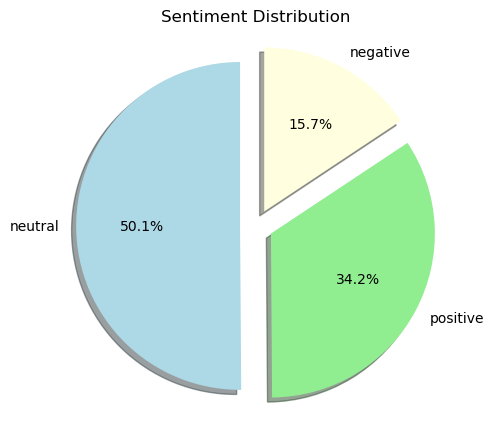

In [27]:
# Call the function to plot the sentiment distribution for the 'df_train' DataFrame.
plot_sentiment_pie(df_train)

In [28]:
# Define a function to plot a bar chart showing the distribution of tweets among sentiment classes.
def plot_sentiment_bar(data):
    # Extract the counts of each sentiment category and their corresponding labels from the 'sentiments' column.
    sentiment_counts = data['sentiments'].value_counts()
    # assign the index and values of each sentiment to the variables labels and counts
    labels = sentiment_counts.index
    counts = sentiment_counts.values
    
    # Create a figure for the bar chart with a specific size (6x5 inches).
    plt.figure(figsize=(6, 5))
    # Define a color palette for the bar chart using Seaborn.
    color_palette = sns.color_palette("dark")
    # Plot the bar chart using Seaborn, specifying the x-axis as sentiment labels and y-axis as tweet counts.
    ax = sns.barplot(x=labels, y=counts, palette=color_palette)
    # Add labels and a title to the plot.
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Tweets')
    plt.title('Number of Tweets per Sentiment')

    # Loop through the individual bars in the chart to annotate each bar with its count.
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    # Display the bar chart.
    plt.show()

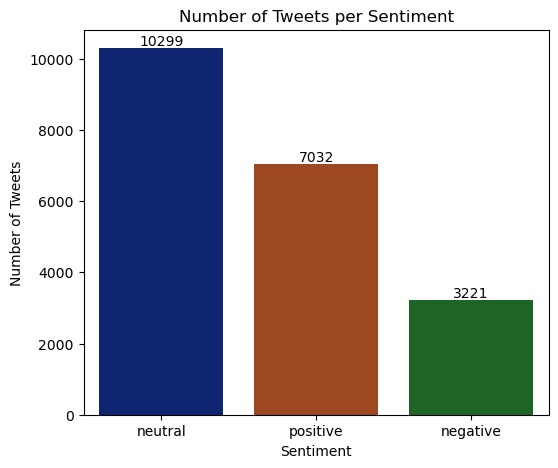

In [29]:
# Call the function to plot the sentiment distribution for the 'df_train' DataFrame.
plot_sentiment_bar(df_train)

In [30]:
# Define a function to plot a bar chart showing the distribution of the most common words in a given column of the data.
def plot_word_distribution(data, column):
    # Concatenate all text in the specified column into a single string.
    all_tweets = ' '.join(data[column].astype(str).values)
    # Split the text into individual words.
    words = all_tweets.split()
    # Count the frequency of each word and sort them in descending order.
    word_frequency = pd.Series(words).value_counts().sort_values(ascending=False)

    # Select the top 10 most frequent words.
    top_words = word_frequency.head(10)

    # Create a new figure with a specific size of 10 units in width and 6 units in height
    plt.figure(figsize=(10, 6))
    # Create a bar plot using seaborn (sns) where the x-axis represents the values (word frequencies) 
    # and the y-axis represents the words, with a dark color palette for styling
    sns.barplot(x=top_words.values, y=top_words.index, palette='dark')
    # Set the label for the x-axis
    plt.xlabel('Frequency')
    # Set the label for the y-axis
    plt.ylabel('Word')
    # Set the title of the plot
    plt.title('Word Distribution')
    # Display the plot
    plt.show()

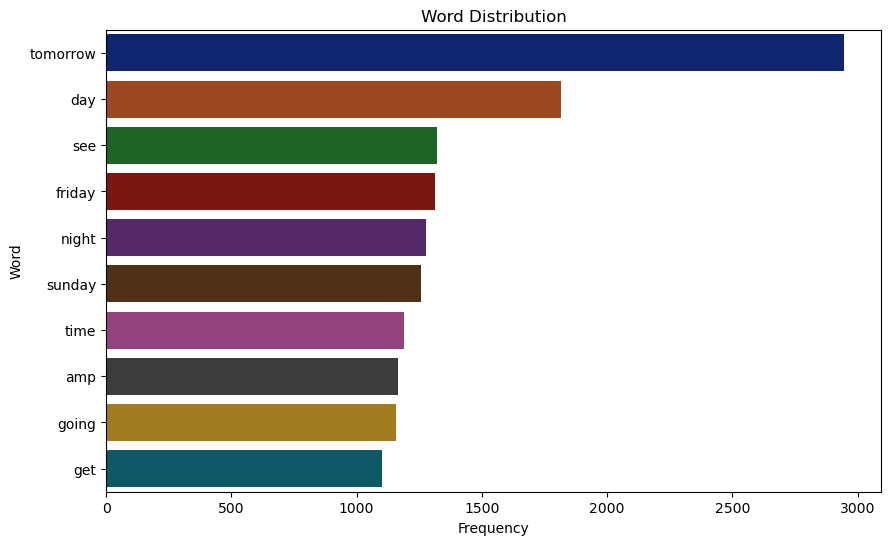

In [31]:
# Call the function to plot word distribution for the 'clean_tweets' column of the 'df_train' DataFrame.
plot_word_distribution(df_train, 'clean_tweets')

In [32]:
# Define a function to generate word clouds for each sentiment category in the training dataset.
def generate_word_clouds(dataframe, sentiment_column, tweet_column):
    # Get unique sentiment categories present in the specified column.
    sentiment_category = dataframe[sentiment_column].unique()
    
    # Iterate through each sentiment category.
    for sentiment in sentiment_category:
        # Filter tweets that belong to the current sentiment category.
        tweets = dataframe[dataframe[sentiment_column] == sentiment][tweet_column]
        # Ensure all tweet entries are treated as strings.
        tweets = tweets.astype(str)
        
        # Combine all tweets into a single text string.
        text = " ".join(tweets)
        
        # Generate a word cloud with specified settings.
        wordcloud = WordCloud(height=800, width=800, background_color="black").generate(text)
        
        # Create a figure for displaying the word cloud.
        plt.figure(figsize=(10, 6))
        # Display the word cloud image using bilinear interpolation.
        plt.imshow(wordcloud, interpolation='bilinear')
        # Set a title for the word cloud based on the current sentiment.
        plt.title(f"wordcloud-{sentiment}")
        # Turn off axis labels.
        plt.axis('off')
        # Show the word cloud plot.

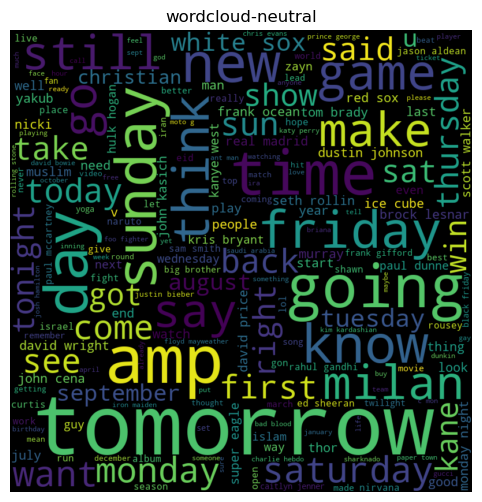

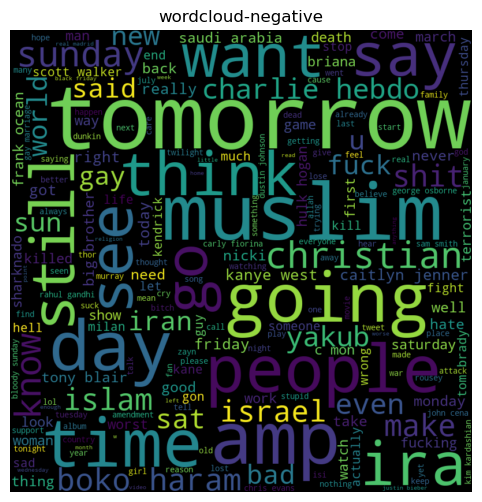

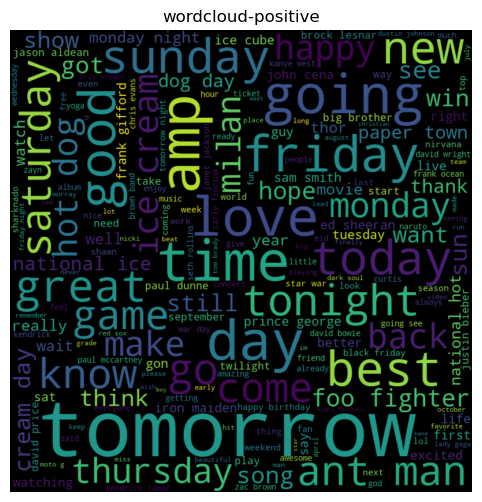

In [33]:
# Call the function to generate word clouds for sentiments using the 'df_train' DataFrame.
generate_word_clouds(df_train, 'sentiments', 'clean_tweets')

## Data Exploration of Test Data

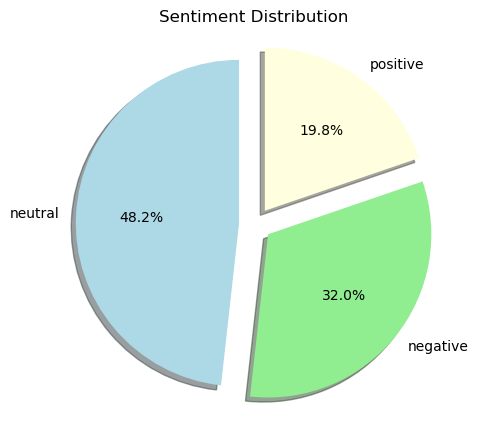

In [34]:
# Call the function to plot the sentiment distribution for the 'df_test' DataFrame.
plot_sentiment_pie(df_test)

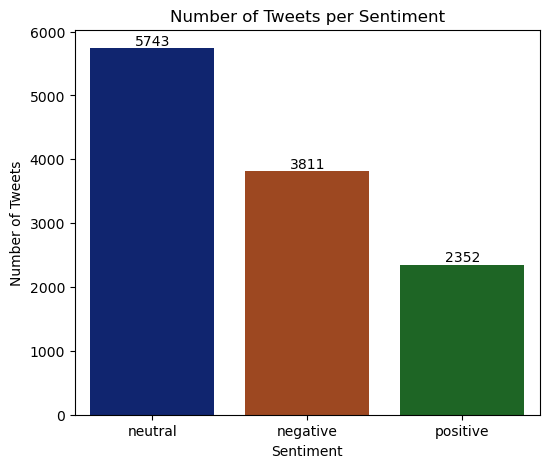

In [35]:
# Call the function to plot the sentiment distribution for the 'df_test' DataFrame.
plot_sentiment_bar(df_test)

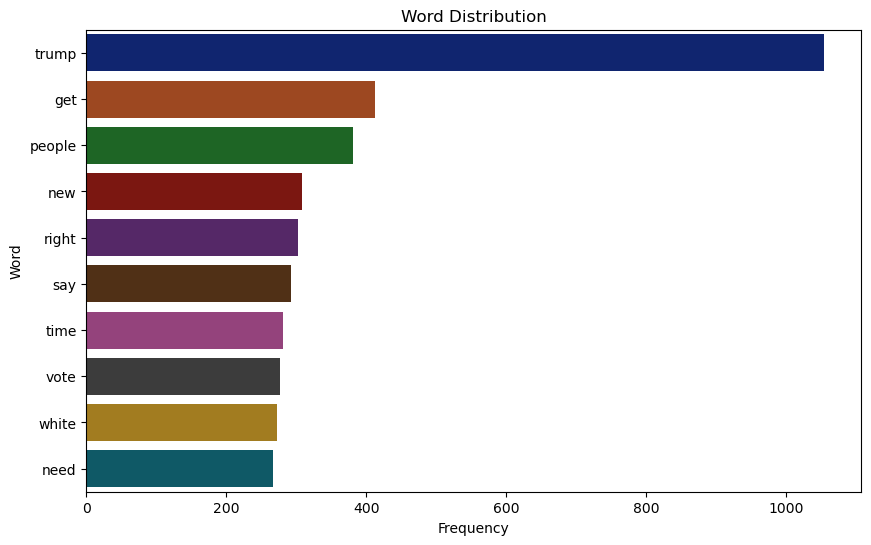

In [36]:
# Call the function to plot word distribution for the 'clean_tweets' column of the 'df_test' DataFrame.
plot_word_distribution(df_test, 'clean_tweets')

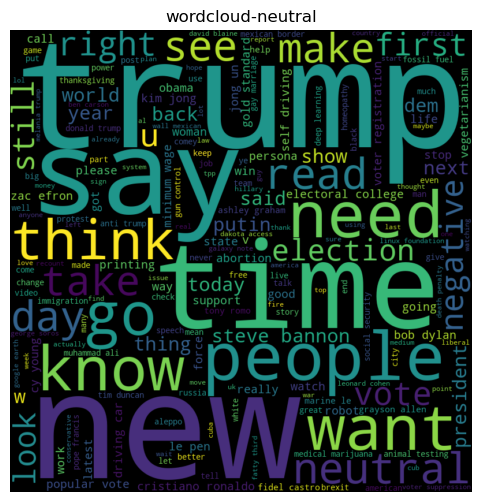

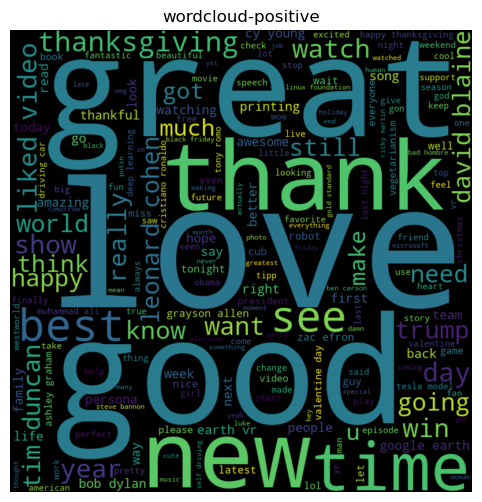

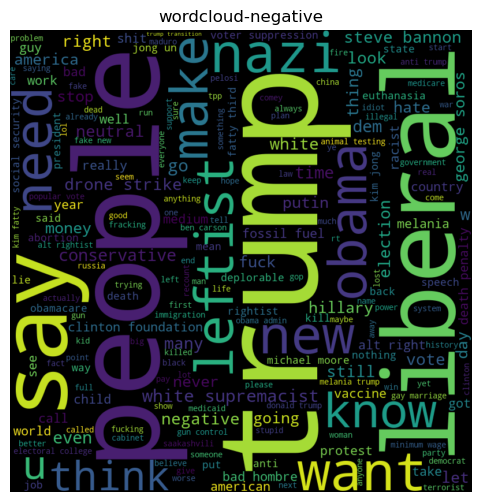

In [37]:
# Call the function to generate word clouds for sentiments using the 'df_test' DataFrame.
generate_word_clouds(df_test, 'sentiments', 'clean_tweets')

## Data Mapping

In [38]:
# using a dictionary to map each sentiment label to a corresponding numeric value
sentiment_mapping = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}

# mapping all sentiments in the clean_train_data sentiment column to numerical values
df_train['sentiments'] = clean_train_data['sentiments'].map(sentiment_mapping)

# mapping all sentiments in the clean_test_data sentiment column to numerical values
df_test['sentiments'] = clean_test_data['sentiments'].map(sentiment_mapping)

## Column Assignment

In [39]:
# df_train is the dataframe that holds both clean tweets and sentiments
# assigning the data from "clean_tweets" columns to training data
training_data = df_train["clean_tweets"]
# assigning the data from "sentiments" columns to training labels
training_labels = df_train["sentiments"]


# df_train is the dataframe that holds both clean tweets and sentiments
# assigning the data from "clean_tweets" columns to training data
testing_data = df_test["clean_tweets"]
# assigning the data from "sentiments" columns to testing_labels
testing_labels = df_test["sentiments"]

## Data Splitting

In [40]:
# splitting the training data and training labels - X and Y where X=70% and Y=30%
x_train, x_val, y_train, y_val = train_test_split(training_data, training_labels, test_size=0.3, random_state=42)

In [41]:
# printing shapes of each data split set
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(14386,) (6166,) (14386,) (6166,)


# Data Validation, Classification, and Evaluation

## Classification Models
#### Base Models

In [42]:
# This code defines a list named models_list, which contains tuples. Each tuple consists of two elements: 
# the name of a classification model and an instance of the corresponding classifier. Each classifier is initialized 
# with random_state=42, which is a common practice to ensure reproducibility of results. The classifiers include:

models_list= [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('SGD Classifier', SGDClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('SVM', SVC(random_state=42)),
]

#### Ensemble Models

In [43]:
# These functions are utility functions to create ensemble classifiers. The functions take in a list of estimator models, 
# which are tuples containing the name and model instance of each classifier. They then return the corresponding ensemble
# classifiers.


# This function creates an ensemble voting classifier. It takes a list of estimator models (classifier instances) as input 
# and returns a voting classifier that uses the majority vote from these classifiers to make predictions.
def ensemble_voting(estimator_models):
    voting_classifier = VotingClassifier(estimators=estimator_models, voting='hard')
    return voting_classifier

    
# This function creates a weighted majority voting classifier. It takes a list of estimator models and corresponding model
# weights as input. The ensemble voting classifier is created with weights assigned based on the provided model_weights, 
# which are typically calculated using evaluation metrics like F1 score.
def ensemble_weighted_voting(estimator_models, model_weights):
    # Create the ensemble voting classifier with weights based on F1 scores
    weighted_voting_classifier = VotingClassifier(estimators=estimator_models, voting='hard', weights=model_weights)
    return weighted_voting_classifier


# This function creates an ensemble stacking classifier. It takes a list of estimator models and a final_estimator as input.
# The stacking classifier is designed to combine the predictions of the base estimators (estimator_models) using the 
# final_estimator.
def ensemble_stacking(estimator_models, final_estimator):
    # Create and return the StackingClassifier
    stacking_classifier = StackingClassifier(estimators=estimator_models, final_estimator=final_estimator)
    # return ensemble classifier
    return stacking_classifier

## Validation Function

In [44]:
# define a validation function with parameters- classification models, training vectors and training labels
# Calculate accuracy using cross_val_score function.
# The cross_val_score function performs cross-validation for the current model.
# It uses the provided 'train_vectors' (feature vectors) and 'train_label' (labels) as the training data.
# The 'scoring' parameter is set to 'accuracy' and 'f1 score' so it will calculate the accuracy of each model using 
# cross-validation.
# The 'cv' parameter specifies the cross-validation strategy (StratifiedKFold in this case).
# The 'n_jobs' parameter is set to -1 to use all available CPU cores for faster computation.
# The 'error_score' parameter is set to 'raise', which means any error during cross-validation will 
# raise an exception.



def perform_validation(models, train_vectors, train_label):
    # Create a StratifiedKFold object with 5 splits for cross-validation.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Lists to store the results for each model
    model_accuracy_scores = []
    model_f1_scores = []
    
    # Iterate through each model and its associated name
    for model_name, model_instance in models:
        print("Training and evaluating", model_name)

        # Calculate accuracy and F1 scores using cross_val_score function
        cv_results = cross_validate(model_instance, train_vectors, train_label, scoring=['accuracy', 'f1_macro'], cv=cv, 
                                 n_jobs=-1, error_score='raise')
        
        # Extract accuracy and F1 scores from the cv_results
        accuracy_scores = cv_results['test_accuracy']
        f1_scores = cv_results['test_f1_macro']
        
        # Append the accuracy and F1 scores to the lists of model results along with the model name
        model_accuracy_scores.append((model_name, accuracy_scores))
        model_f1_scores.append((model_name, f1_scores))

    # Return the lists of model accuracy scores and model F1 scores
    return model_accuracy_scores, model_f1_scores

## parameter distribution list

In [66]:
# Define the parameter distributions for each classifier
param_dist = {
    'Logistic Regression': {
        'C': uniform(0.1, 1.0),                      # Regularization strength (uniform distribution between 0.01 and 1.0)
        'solver': ['liblinear', 'newton-cg','saga']  # Solvers for optimization
    },
    'SGD Classifier': {
        'loss': ['hinge', 'log_loss', 'modified_huber'], # Loss functions for stochastic gradient descent
        'alpha': uniform(0.001, 0.01),              # Regularization parameter (uniform distribution between 0.001 and 0.01)
        'max_iter': randint(200, 400),               # Maximum number of iterations
    },
    'Random Forest': {
        'n_estimators': [173, 174, 175, 177],       # Number of trees in the forest
        'max_depth': [20],                  # Maximum depth of the tree (None means unlimited, 10 and 20 are options)
        'min_samples_split': randint(1, 10),    # Minimum number of samples required to split an internal node
        'min_samples_leaf': randint(1, 5)        # Minimum number of samples required to be at a leaf node
    },
    'Decision Tree': {
        'criterion': ['entropy'],                  # Function to measure the quality of a split
        'max_depth': [20],                     # Maximum depth of the tree (None means unlimited, 10 and 20 are options)
        'min_samples_split': randint(1, 10),       # Minimum number of samples required to split an internal node
        'min_samples_leaf': randint(1, 5)          # Minimum number of samples required to be at a leaf node
    },
    'SVM': {
        'C': [1.0, 10.0],                           # Regularization parameter values to try
        'kernel': ['rbf'],                          # Kernel type for SVM
        'gamma': ['scale', 0.1]                     # Kernel coefficient for 'rbf' kernels
    }
}


## Parameter Tuning Function

In [46]:
# This function takes a list of classifiers, their parameter distributions, training vectors, and training labels. 
# It performs RandomizedSearchCV (Randomized Search Cross Validation) to find the best hyperparameters for each classifier. 
# It uses accuracy and F1-score with macro averaging as scoring metrics. The best hyperparameters, accuracy, and F1-score 
# for each classifier are printed, and the best classifier with its hyperparameters is stored in the best_parameters list. 
# Finally, the list of best classifiers and their hyperparameters is returned.

def get_best_params(models, param_dist, train_vectors, train_label):
    
    # Create an empty list to store the classifiers and their hyperparameters
    best_parameters = []

    # Define the scoring metric (accuracy and f1_macro)
    scoring = {
        'accuracy': 'accuracy',
        'f1_macro': make_scorer(f1_score, average='macro')
    }

    # Loop through each classifier and its parameter distribution
    for name, classifier in models:
        print("Performing RandomizedSearchCV for", name)

        # Assign the hyperparameter distribution associated with a specific 'name' to 'param_dist_classifier'.
        param_dist_classifier = param_dist[name]

        
        # Perform RandomizedSearchCV on the classifier
        # Create a RandomizedSearchCV object for hyperparameter tuning of a classifier.
        # 'classifier' represents the machine learning classifier you want to tune.
        # 'param_dist_classifier' contains the hyperparameter distribution you want to explore.
        # 'n_iter=5' specifies the number of parameter settings that are sampled.
        # 'cv=10' sets up a 10-fold cross-validation strategy for evaluating the hyperparameters.
        # 'scoring' specifies the scoring metric to optimize (e.g., accuracy, F1-score, etc.).
        # 'refit' indicates that the best model should be refitted with the 'accuracy' metric.
        # 'n_jobs=-1' allows parallel processing with all available CPU cores.
        # 'random_state=42' sets the random seed for reproducibility.
        random_search = RandomizedSearchCV(classifier, param_distributions=param_dist_classifier,
                                   n_iter=5, cv=10, scoring=scoring, refit='accuracy',
                                   n_jobs=-1, random_state=42)

        # Fit the RandomizedSearchCV object to the training data.
        # 'train_vectors' contains the feature vectors of the training data.
        # 'train_label' contains the corresponding labels.
        random_search.fit(train_vectors, train_label)


        # Get the best estimator (classifier model) identified by the RandomizedSearchCV.
        best_classifier = random_search.best_estimator_
        # Get the best hyperparameters that resulted in the highest scoring metric (e.g., accuracy).
        best_hyperparameters = random_search.best_params_
        # Get the best accuracy score achieved during hyperparameter tuning.
        best_accuracy = random_search.best_score_
        # Get the best F1 macro score (or any other desired metric) achieved during hyperparameter tuning.
        # 'mean_test_f1_macro' is a key in the 'cv_results_' dictionary that stores the mean test F1 macro scores.
        # 'random_search.best_index_' returns the index of the best model, which corresponds to the best F1 score.
        best_f1_score = random_search.cv_results_['mean_test_f1_macro'][random_search.best_index_]


        # Print the results
        print("Best hyperparameters for", name, ":", best_hyperparameters)
        print()


        # Append the best classifier, its hyperparameters, accuracy, and F1 score to the list
        best_parameters.append((name, best_classifier, best_hyperparameters, best_accuracy, best_f1_score))

    return best_parameters

## Classification of Models Using BoW

### Feature Extraction of training and test data

In [47]:
# Initializing the count vectorizer
count_vec = CountVectorizer(max_features=15000)

# Perform vectorization on the training data
count_train_data= count_vec.fit_transform(x_train)

# Transforming validation data using the same vocabulary as training data
count_val_data= count_vec.transform(x_val)

# Transforming final testing data using the same vocabulary as training data
count_test_data = count_vec.transform(testing_data)

### Oversampling of training data to handle data imbalance

In [48]:
# These lines of code apply the SMOTE technique to balance the class distribution in the training data
# by generating synthetic samples for the minority class.

# Create an instance of the SMOTE (Synthetic Minority Over-sampling Technique) oversampler.
# 'sampling_strategy='auto'' indicates that SMOTE will balance the classes by generating synthetic samples.
# 'random_state=42' sets the random seed for reproducibility.
oversampler = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the training data and labels.
# 'count_train_data' represents the feature vectors of the training data.
# 'y_train' contains the corresponding class labels.
count_train_oversampled, count_labels_oversampled = oversampler.fit_resample(count_train_data, y_train)

### Parameter Tuning to obtain the best classification hyperparameters for each base model

In [49]:
# Call the function 'get_best_params' with specific arguments to obtain the best hyperparameters for the models.
# 'models_list' is a list of machine learning models to be tuned.
# 'param_dist' is a dictionary containing hyperparameter distributions for the models.
# 'count_train_oversampled' is the oversampled training data.
# 'count_labels_oversampled' are the corresponding labels.
count_best_params = get_best_params(models_list, param_dist, count_train_oversampled, count_labels_oversampled)

Performing RandomizedSearchCV for Logistic Regression
Best hyperparameters for Logistic Regression : {'C': 0.5592488919658671, 'solver': 'liblinear'}

Performing RandomizedSearchCV for SGD Classifier
Best hyperparameters for SGD Classifier : {'alpha': 0.0024286681792194077, 'loss': 'modified_huber', 'max_iter': 349}

Performing RandomizedSearchCV for Random Forest
Best hyperparameters for Random Forest : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 174}

Performing RandomizedSearchCV for Decision Tree
Best hyperparameters for Decision Tree : {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}

Performing RandomizedSearchCV for SVM
Best hyperparameters for SVM : {'kernel': 'rbf', 'gamma': 0.1, 'C': 1.0}



### Function to create a list of base models with best hyperparameters

In [50]:
# This code defines a function get_models that creates different machine learning models with the best hyperparameters
# obtained from a previous optimization process. The function returns a list of tuples where each tuple contains 
# the model's name and the corresponding instantiated model with the best hyperparameters.

def get_models(best_params):
    models = {}
    
    # Create a Logistic Regression model with the best hyperparameters (stored in best_params[0][2])
    models['Logistic Regression'] = LogisticRegression(**best_params[0][2], random_state=42)
    # Create an SGD Classifier model with the best hyperparameters (stored in best_params[1][2])
    models['SGD Classifier'] = SGDClassifier(**best_params[1][2])
    # Create a Random Forest model with the best hyperparameters (stored in best_params[2][2])
    models['Random Forest'] = RandomForestClassifier(**best_params[2][2], random_state=42)
    # Create a Decision Tree model with the best hyperparameters (stored in best_params[3][2])
    models['Decision Tree'] = DecisionTreeClassifier(**best_params[3][2], random_state=42)
    # Create an SVM model with the best hyperparameters (stored in best_params[4][2])
    models['SVM'] = SVC(**best_params[4][2], random_state=42)
    # Combine the model names and corresponding models into a list of tuples called estimators
    estimators = [(name, model) for name, model in models.items()]

    return estimators

### Validation of Base Models

In [51]:
# Get the models with best hyperparameters
models_with_best_params = get_models(count_best_params)

# Create a list called 'results_models' using a list comprehension.
# The list will contain tuples, where each tuple consists of a model name and its validation results.
results_models = [
    # For each 'name, model' pair in 'models_with_best_params':
    (name, perform_validation([(name, model)], count_train_oversampled, count_labels_oversampled))
    for name, model in models_with_best_params
]

#print statement
print("Validation Complete")

Training and evaluating Logistic Regression
Training and evaluating SGD Classifier
Training and evaluating Random Forest
Training and evaluating Decision Tree
Training and evaluating SVM
Validation Complete


### Normalization of F1 scores for utilization as model weights

In [52]:
# normalized_f1_weights lists will contain the normalized weights used in computing the ensemble weighted voting
# These weights will ensure that the contribution of each model is proportional to its performance in terms 
# of F1 score.


# Initialize lists to store mean accuracy and F1 scores
mean_f1_scores = []

# Loop through the 'results_models' list, unpacking accuracy and F1 score results for each model.
for _, (accuracy_scores, f1_scores) in results_models:
    # Calculate the mean F1 score for the current model.
    mean_f1 = np.mean([score for _, scores in f1_scores for score in scores])
    # Append the mean F1 score to the 'mean_f1_scores' list.
    mean_f1_scores.append(mean_f1)


# Calculate the sum of all the mean F1 scores.
sum_f1 = sum(mean_f1_scores)
# Calculate normalized F1 score weights for each model based on their mean F1 scores.
normalized_f1_weights = [f1 / sum_f1 for f1 in mean_f1_scores]
# Print the list of normalized F1 score weights.
print(normalized_f1_weights)

[0.21668505799665355, 0.2139087561549259, 0.1916653625829608, 0.16156310078694935, 0.2161777224785105]


### Creating Ensemble Classifiers with Optimized Models

In [53]:
# Call the 'get_models' function with 'count_best_params' as an argument.
# 'count_best_params'  contains the best hyperparameters for creating the models.
models_with_best_params = get_models(count_best_params)


# Create an ensemble voting classifier using the ensemble_voting function.
# 'models_with_best_params' is a list of machine learning models with their best hyperparameters.
ensemble_voting_classifier = ensemble_voting(models_with_best_params)


# Create a weighted voting classifier using the ensemble_weighted_voting function.
# 'models_with_best_params' is a list of machine learning models with their best hyperparameters.
# 'normalized_f1_weights' is a list of weights assigned to each model based on their mean F1 scores.
weighted_voting_classifier = ensemble_weighted_voting(models_with_best_params, normalized_f1_weights)


# Create a stacking classifier using the ensemble_stacking function.
# 'models_with_best_params' is a list of machine learning models with their best hyperparameters.
# 'LogisticRegression(**count_best_params[0][2])' creates a Logistic Regression meta-classifier
# using hyperparameters obtained from the first model in the list (count_best_params).
stacking_classifier = ensemble_stacking(models_with_best_params, LogisticRegression(**count_best_params[0][2]))

### Validation of Ensemble classifiers

In [54]:
# Call the 'perform_validation' function to evaluate the performance of an ensemble voting classifier.
# The ensemble voting classifier is specified as ('ensemble Voting Classifier', ensemble_voting_classifier).
# It is evaluated on the oversampled training data 'count_train_oversampled' and corresponding labels.
results_voting = perform_validation([('ensemble Voting Classifier', ensemble_voting_classifier)],
                                    count_train_oversampled, count_labels_oversampled)


# Call the 'perform_validation' function to evaluate the performance of an ensemble weighted voting classifier.
# The ensemble weighted voting classifier is specified ('ensemble Weighted Voting Classifier', weighted_voting_classifier)
# It is evaluated on the oversampled training data 'count_train_oversampled' and corresponding labels.
results_weighted_voting = perform_validation([('ensemble Weighted Voting Classifier', weighted_voting_classifier)],
                                            count_train_oversampled, count_labels_oversampled)


# Call the 'perform_validation' function to evaluate the performance of an ensemble stacking classifier.
# The ensemble stacking classifier is specified as ('ensemble Stacking Classifier', stacking_classifier).
# It is evaluated on the oversampled training data 'count_train_oversampled' and corresponding labels.
results_stacking = perform_validation([('ensemble Stacking Classifier', stacking_classifier)],
                                      count_train_oversampled, count_labels_oversampled)

# Print a message to indicate that the validation process has been completed.
print("Validation completed")

Training and evaluating ensemble Voting Classifier
Training and evaluating ensemble Weighted Voting Classifier
Training and evaluating ensemble stacking Classifier
Validation completed


### Aggregating and Analyzing Model Validation Results for Count Vectors

In [55]:
# Initialize an empty list named 'count_all_accuracies'.
count_all_accuracies = []

# Iterate through each model's results in 'results_models' (unpacking accuracy and F1 score results).
for _, (accuracy_scores, f1_scores) in results_models:
    # Extract accuracy scores for the current model.
    model_accuracies = [score for _, scores in accuracy_scores for score in scores]
    # Append the accuracy scores for the current model to 'count_all_accuracies'.
    count_all_accuracies.append(model_accuracies)


# Append the ensemble voting accuracy at index one to the count_all_accuracies list
count_all_accuracies.append(results_voting[0][0][1].tolist())
# Append the weighted voting accuracy at index one to the count_all_accuracies list
count_all_accuracies.append(results_weighted_voting[0][0][1].tolist())
# Append the ensemble stacking accuracy at index one to the count_all_accuracies list
count_all_accuracies.append(results_stacking[0][0][1].tolist())


# put all the model names in one list
# Use a list comprehension to extract the names from the tuples (name, model)
count_all_names = [name for name, (accuracy_scores, f1_scores) in results_models]
# Append the names of the ensemble voting, weighted majority voting, and ensemble stacking classifiers to count_all_names
count_all_names.append("Ensemble Voting")
count_all_names.append("Weighted Majority Voting")
count_all_names.append("Ensemble Stacking")


# Iterate through pairs of 'name' and 'acc_scores' using the 'zip' function.
for name, acc_scores in zip(count_all_names, count_all_accuracies):
    # Calculate the mean accuracy score for the current model.
    count_mean_acc_score = np.mean(acc_scores)
    # Calculate the standard deviation of accuracy scores for the current model.
    count_std_acc_score = np.std(acc_scores)
    # Print the model name, mean accuracy, and standard deviation of accuracy.
    print(f"{name} - Mean_accuracy: {count_mean_acc_score:.3f}, Std_accuracy: {count_std_acc_score:.3f}")
    # Print a separator line.
    print("------------------------------------")

Logistic Regression - Mean_accuracy: 0.678, Std_accuracy: 0.005
------------------------------------
SGD Classifier - Mean_accuracy: 0.670, Std_accuracy: 0.006
------------------------------------
Random Forest - Mean_accuracy: 0.605, Std_accuracy: 0.009
------------------------------------
Decision Tree - Mean_accuracy: 0.520, Std_accuracy: 0.006
------------------------------------
SVM - Mean_accuracy: 0.675, Std_accuracy: 0.005
------------------------------------
Ensemble Voting - Mean_accuracy: 0.668, Std_accuracy: 0.005
------------------------------------
Weighted Majority Voting - Mean_accuracy: 0.673, Std_accuracy: 0.004
------------------------------------
Ensemble Stacking - Mean_accuracy: 0.683, Std_accuracy: 0.003
------------------------------------


### Visualize Validation Accuracies with a Box Plot

In [56]:
# A 'data' list is created to store the model names and their corresponding accuracies.
# This is done by iterating through count_all_names and count_all_accuracies simultaneously and creating 
# dictionaries with the model name and corresponding accuracy. 
# The data list is then used to create a pandas DataFrame count_df.
# The 'Accuracy' column in count_df is converted to numeric using pd.to_numeric to ensure that the data is in the 
# correct format for calculations. 
# Mean and standard deviation scores are calculated for each model's results using groupby and mean() and std() functions, 
# respectively, and the results are stored in the mean_scores and std_scores DataFrames.
# Finally, an interactive box plot is created using Plotly Express (px.box) to visualize and compare the accuracy 
# distributions of different models and ensembles. The 'Model/Ensemble' column is used as the x-axis,
# 'Accuracy' column as the y-axis, and 'all' points are shown on the plot. The plot title is set to 'Model and 
# Ensemble Accuracy Comparison'. The interactive plot is then displayed using fig.show().



# Create the list of dictionaries for each model and accuracy
data = []
for name, accuracies in zip(count_all_names, count_all_accuracies):
    for accuracy in accuracies:
        data.append({'Model/Ensemble': name, 'Accuracy': accuracy})

# Create the DataFrame with the data
count_df = pd.DataFrame(data)

# Convert 'Accuracy' column to numeric
count_df['Accuracy'] = pd.to_numeric(count_df['Accuracy'], errors='coerce')

# Calculate the mean and standard deviation for each model's results
mean_scores = count_df.groupby('Model/Ensemble')['Accuracy'].mean().reset_index()
std_scores = count_df.groupby('Model/Ensemble')['Accuracy'].std().reset_index()

# Create the interactive box plot using Plotly Express
fig = px.box(count_df, x='Model/Ensemble', y='Accuracy', points='all', hover_data=['Model/Ensemble'],
             title='Model and Ensemble Accuracy Comparison', width=800, height=600)

# Show the interactive plot
fig.show()

### Function for Classification and Evaluation of Base Models

In [57]:
# The models_classification function takes a list of best_params_list containing the best hyperparameters for each 
# classifier, as well as the training and test data along with their corresponding labels. It trains each classifier 
# with the best hyperparameters on the training data, makes predictions on the test data, and evaluates the classifiers 
# using accuracy, f1-score, and average recall. It also generates the classification report and confusion matrices for 
# each classifier, and stores the results in a dictionary named results.The function then prints the 
# evaluation metrics and classification reports for each classifier, and plots a heatmap for each confusion matrix using 
# seaborn's heatmap function. It appends all the confusion matrices to the list, all_cms for later use. 
# Finally, the function returns two outputs as a tuple: the results dictionary containing the evaluation results for 
# each classifier, and the list all_cms containing all the confusion matrices.


def models_classification(best_params_list, train_data, train_labels, test_data, test_labels, class_labels):
    results = {}  # Initialize an empty dictionary to hold the evaluation results for each classifier
    all_cms = []  # List to store confusion matrices of all classifiers
    normalized_weighted_f1_list = []  # List to store normalized weighted F1 scores
    
    
    # Loop through the best_params_list containing tuples of (name, best_classifier, best_hyperparameters, _, _)
    for name, best_classifier, best_hyperparameters, _, _ in best_params_list:
        # Set the best_classifier as the classifier
        classifier = best_classifier
        
        # Set the best hyperparameters on the classifier
        classifier_with_params = classifier.set_params(**best_hyperparameters)
        
        # Print the classifier with the best hyperparameters
        print(classifier_with_params)
        
        # Train the classifier_with_params on the training data and labels
        classifier_with_params.fit(train_data, train_labels)
        
        # Make predictions on the test data using the trained classifier
        predicted_labels = classifier_with_params.predict(test_data)
        
        # Evaluate the performance of the classifier by calculating accuracy, f1-score, and average recall
        accuracy = accuracy_score(test_labels, predicted_labels)  # Calculate accuracy
        f1 = f1_score(test_labels, predicted_labels, average='macro')  # Calculate f1-score
        recall = recall_score(test_labels, predicted_labels, average='macro')  # Calculate average recall
        
        # Generate the classification report
        classification_rep = classification_report(test_labels, predicted_labels)
        
        # Print evaluation reports and classification reports for the current classifier
        print("Accuracy for {}: {:.3f}".format(name, accuracy))
        print("F1 Score for {}: {:.3f}".format(name, f1))
        print("Average Recall for {}: {:.3f}".format(name, recall))
        print("Classification Report for {}:".format(name))
        print(classification_rep)
        print()
        
        # Generate the confusion matrix using scikit-learn's confusion_matrix function
        cm = confusion_matrix(test_labels, predicted_labels)
        all_cms.append(cm)  # Append the confusion matrix to the list for later use

        # Plot the heatmap for the confusion matrix using seaborn's heatmap function
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix - {}'.format(name))
        plt.show()
        
        
        # Print a message indicating that classification errors are being analyzed for a specific model.
        print(f'Analysing Classification Errors in: {name.upper()}')
        # Iterate through the class labels.
        for i in range(len(class_labels)):
            for j in range(len(class_labels)):
                # Check if 'i' is not equal to 'j' and if there are errors between these classes.
                if i != j and cm[i, j] > 0:
                    # Print a message indicating how many times class 'i' was classified as class 'j'.
                    print(f"{class_labels[i]} classified as {class_labels[j]}: {cm[i, j]} times")
        # Print an empty line for separation between different models' analysis.
        print()

                    

        # Store the evaluation results (accuracy, f1-score, average recall, classification report, confusion matrix) 
        # in the dictionary
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'average_recall': recall,
            'classification_report': classification_rep,
            'confusion_matrix': cm
        }
    
    # Return the evaluation results dictionary and the list of confusion matrices as a tuple
    return results, all_cms

### Classification and Evaluation of Base Models

LogisticRegression(C=0.5592488919658671, random_state=42, solver='liblinear')
Accuracy for Logistic Regression: 0.621
F1 Score for Logistic Regression: 0.589
Average Recall for Logistic Regression: 0.591
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          -1       0.46      0.47      0.46       957
           0       0.65      0.64      0.64      3013
           1       0.66      0.66      0.66      2196

    accuracy                           0.62      6166
   macro avg       0.59      0.59      0.59      6166
weighted avg       0.62      0.62      0.62      6166




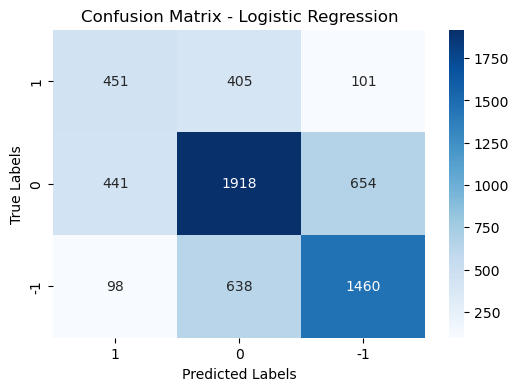

Analysing Classification Errors in:LOGISTIC REGRESSION
1 classified as 0: 405 times
1 classified as -1: 101 times
0 classified as 1: 441 times
0 classified as -1: 654 times
-1 classified as 1: 98 times
-1 classified as 0: 638 times

SGDClassifier(alpha=0.0024286681792194077, loss='modified_huber', max_iter=349,
              random_state=42)
Accuracy for SGD Classifier: 0.618
F1 Score for SGD Classifier: 0.585
Average Recall for SGD Classifier: 0.587
Classification Report for SGD Classifier:
              precision    recall  f1-score   support

          -1       0.43      0.47      0.45       957
           0       0.64      0.65      0.64      3013
           1       0.68      0.64      0.66      2196

    accuracy                           0.62      6166
   macro avg       0.58      0.59      0.58      6166
weighted avg       0.62      0.62      0.62      6166




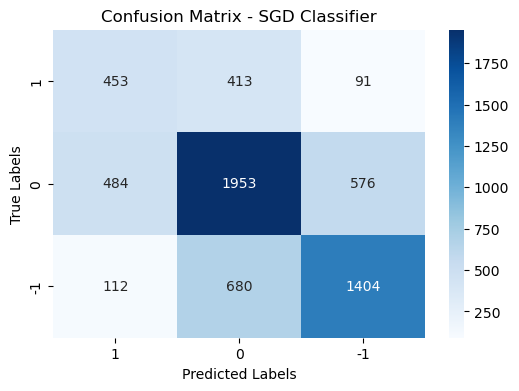

Analysing Classification Errors in:SGD CLASSIFIER
1 classified as 0: 413 times
1 classified as -1: 91 times
0 classified as 1: 484 times
0 classified as -1: 576 times
-1 classified as 1: 112 times
-1 classified as 0: 680 times

RandomForestClassifier(max_depth=20, min_samples_split=7, n_estimators=174,
                       random_state=42)
Accuracy for Random Forest: 0.536
F1 Score for Random Forest: 0.521
Average Recall for Random Forest: 0.552
Classification Report for Random Forest:
              precision    recall  f1-score   support

          -1       0.32      0.59      0.41       957
           0       0.63      0.49      0.55      3013
           1       0.63      0.57      0.60      2196

    accuracy                           0.54      6166
   macro avg       0.52      0.55      0.52      6166
weighted avg       0.58      0.54      0.55      6166




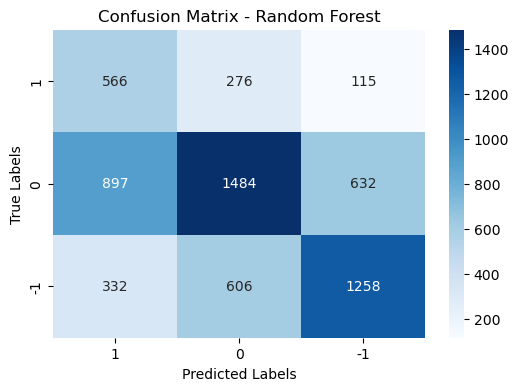

Analysing Classification Errors in:RANDOM FOREST
1 classified as 0: 276 times
1 classified as -1: 115 times
0 classified as 1: 897 times
0 classified as -1: 632 times
-1 classified as 1: 332 times
-1 classified as 0: 606 times

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=5,
                       random_state=42)
Accuracy for Decision Tree: 0.419
F1 Score for Decision Tree: 0.416
Average Recall for Decision Tree: 0.463
Classification Report for Decision Tree:
              precision    recall  f1-score   support

          -1       0.22      0.63      0.33       957
           0       0.55      0.38      0.45      3013
           1       0.61      0.38      0.47      2196

    accuracy                           0.42      6166
   macro avg       0.46      0.46      0.42      6166
weighted avg       0.52      0.42      0.44      6166




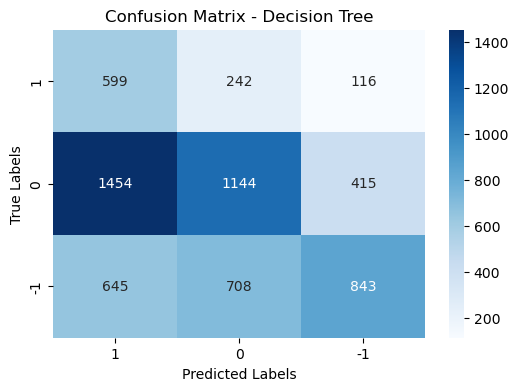

Analysing Classification Errors in:DECISION TREE
1 classified as 0: 242 times
1 classified as -1: 116 times
0 classified as 1: 1454 times
0 classified as -1: 415 times
-1 classified as 1: 645 times
-1 classified as 0: 708 times

SVC(gamma=0.1, random_state=42)
Accuracy for SVM: 0.602
F1 Score for SVM: 0.541
Average Recall for SVM: 0.530
Classification Report for SVM:
              precision    recall  f1-score   support

          -1       0.45      0.30      0.36       957
           0       0.60      0.73      0.66      3013
           1       0.66      0.56      0.61      2196

    accuracy                           0.60      6166
   macro avg       0.57      0.53      0.54      6166
weighted avg       0.60      0.60      0.59      6166




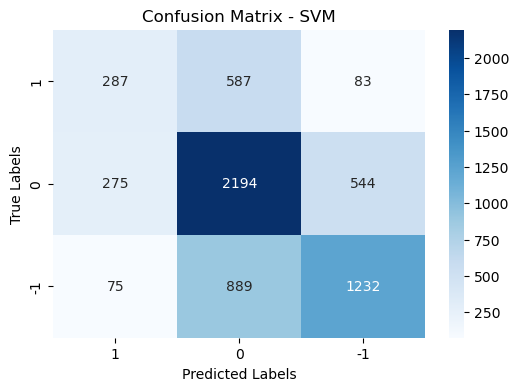

Analysing Classification Errors in:SVM
1 classified as 0: 587 times
1 classified as -1: 83 times
0 classified as 1: 275 times
0 classified as -1: 544 times
-1 classified as 1: 75 times
-1 classified as 0: 889 times



In [58]:
# Call the 'models_classification' function with appropriate parameters
# The function will train and evaluate the classifiers using the specified data
# and return the results and confusion matrices for each classifier

count_results, count_cm = models_classification(
    count_best_params,         # List of best hyperparameters for each classifier
    count_train_oversampled,   # Training data (oversampled) for the classifiers
    count_labels_oversampled,  # Labels for the oversampled training data
    count_val_data,            # Development/validation data for evaluation
    y_val,                     # True labels for the development/validation data
    class_labels=[1, 0, -1]    # Class labels for plotting the confusion matrices
)

### Function for Classification and Evaluation of Ensemble models

In [59]:
# The train_ensemble function takes a dictionary ensemble_classifiers containing the names and corresponding 
# ensemble classifiers as input. It then trains each classifier on the training data, makes predictions on the 
# validation data, calculates evaluation metrics (accuracy, f1-score, average recall), generates the classification report
# and confusion matrix, and stores the results in the ensemble_results dictionary. It also appends the confusion matrices 
# to the all_ensemble_cms list. Finally, it plots a heatmap for each confusion matrix and returns the evaluation results 
# and the list of confusion matrices as a tuple.

def ensemble_classification(ensemble_classifiers, train_data, train_labels, test_data, test_labels, class_labels):
    ensemble_results = {} # Initialize an empty dictionary to hold the evaluation results for each ensemble classifier
    all_ensemble_cms = [] # List to store confusion matrices of all ensemble classifiers
    
    # Loop through each ensemble classifier (name, classifier) in the dictionary ensemble_classifiers
    for name, classifier in ensemble_classifiers.items():
        # Train the classifier on the training data and labels
        classifier.fit(train_data, train_labels)
        
        # Make predictions on the validation data using the trained classifier
        predicted_labels = classifier.predict(test_data)
        
        # Calculate accuracy, f1-score, and average recall for the classifier
        ensemble_accuracy = accuracy_score(test_labels, predicted_labels) # Calculate accuracy
        ensemble_f1 = f1_score(test_labels, predicted_labels, average='macro') # Calculate f1-score
        average_recall = recall_score(test_labels, predicted_labels, average='macro') # Calculate average recall
        
        # Generate the classification report
        ensemble_report = classification_report(test_labels, predicted_labels)
        
        # Generate the confusion matrix using confusion_matrix function
        cm = confusion_matrix(test_labels, predicted_labels)
        all_ensemble_cms.append(cm) # Append the confusion matrix to the list for later use
        
        # Store the evaluation results (accuracy, f1-score, average recall, classification report, confusion matrix) 
        # in the dictionary
        ensemble_results[name] = {
            'accuracy': ensemble_accuracy,
            'f1_score': ensemble_f1,
            'average_recall': average_recall,
            'classification_report': ensemble_report,
            'confusion_matrix': cm
        }
        
        # Print the results for the current classifier evaluation
        print(f"{name} Classifier Accuracy: {ensemble_accuracy:.3f}")
        print(f"{name} Classifier f1_score: {ensemble_f1:.3f}")
        print(f"{name} Classifier average_recall: {average_recall:.3f}")
        print(f"{name} Classifier Classification Report:")
        print(ensemble_report)
        #print a line separator
        print("------------------------------------")
        
        
        # Create a new figure with a specified size (6 inches width by 4 inches height).
        plt.figure(figsize=(6, 4))
        # Create a heatmap of the confusion matrix.
        # 'cm' is the confusion matrix, 'annot=True' displays the values inside the cells,
        # 'fmt='d'' formats the values as integers, 'cmap='Blues'' sets the color map,
        # 'xticklabels' and 'yticklabels' set the labels for the x and y-axis.
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        # Set the label for the x-axis.
        plt.xlabel('Predicted Labels')
        # Set the label for the y-axis.
        plt.ylabel('True Labels')
        # Set the title of the plot, including the name of the model.
        plt.title(f'Confusion Matrix - {name}')
        # Display the plot.
        plt.show()

        
        # Print a message indicating that classification errors are being analyzed for a specific model.
        print(f'Analysing Classification Errors in: {name.upper()}')
        # Iterate through the class labels.
        for i in range(len(class_labels)):
            for j in range(len(class_labels)):
                # Check if 'i' is not equal to 'j' and if there are errors between these classes.
                if i != j and cm[i, j] > 0:
                    # Print a message indicating how many times class 'i' was classified as class 'j'.
                    print(f"{class_labels[i]} classified as {class_labels[j]}: {cm[i, j]} times")
        # Print an empty line for separation between different models' analysis.
        print()
        
    # Return the evaluation results (ensemble_results) and the list of confusion matrices (all_ensemble_cms) as a tuple
    return ensemble_results, all_ensemble_cms

### Classification and Evaluation of Ensemble models

Ensemble Voting Classifier Accuracy: 0.608
Ensemble Voting Classifier f1_score: 0.575
Ensemble Voting Classifier average_recall: 0.579
Ensemble Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.40      0.48      0.44       957
           0       0.63      0.65      0.64      3013
           1       0.69      0.60      0.64      2196

    accuracy                           0.61      6166
   macro avg       0.57      0.58      0.57      6166
weighted avg       0.62      0.61      0.61      6166

------------------------------------


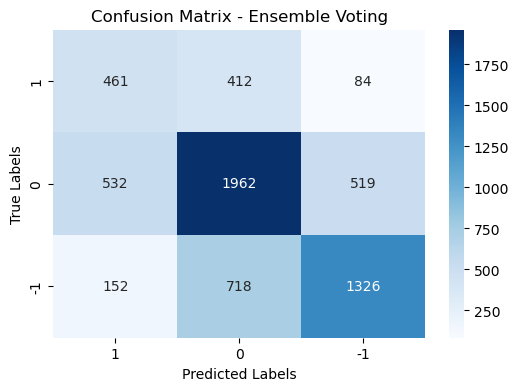

1 classified as 0: 412 times
1 classified as -1: 84 times
0 classified as 1: 532 times
0 classified as -1: 519 times
-1 classified as 1: 152 times
-1 classified as 0: 718 times

Weighted Majority Voting Classifier Accuracy: 0.616
Weighted Majority Voting Classifier f1_score: 0.582
Weighted Majority Voting Classifier average_recall: 0.583
Weighted Majority Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.43      0.47      0.45       957
           0       0.64      0.65      0.65      3013
           1       0.68      0.63      0.65      2196

    accuracy                           0.62      6166
   macro avg       0.58      0.58      0.58      6166
weighted avg       0.62      0.62      0.62      6166

------------------------------------


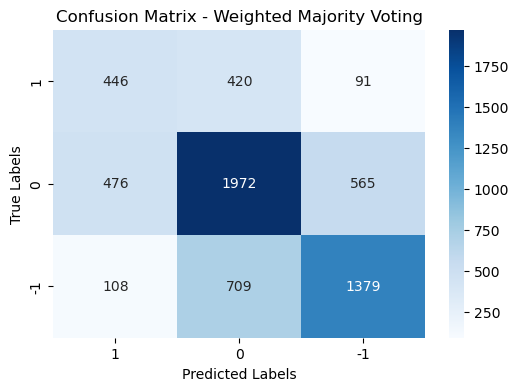

1 classified as 0: 420 times
1 classified as -1: 91 times
0 classified as 1: 476 times
0 classified as -1: 565 times
-1 classified as 1: 108 times
-1 classified as 0: 709 times

Ensemble Stacking Classifier Accuracy: 0.620
Ensemble Stacking Classifier f1_score: 0.580
Ensemble Stacking Classifier average_recall: 0.573
Ensemble Stacking Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.48      0.42      0.45       957
           0       0.63      0.69      0.66      3013
           1       0.67      0.61      0.64      2196

    accuracy                           0.62      6166
   macro avg       0.59      0.57      0.58      6166
weighted avg       0.62      0.62      0.62      6166

------------------------------------


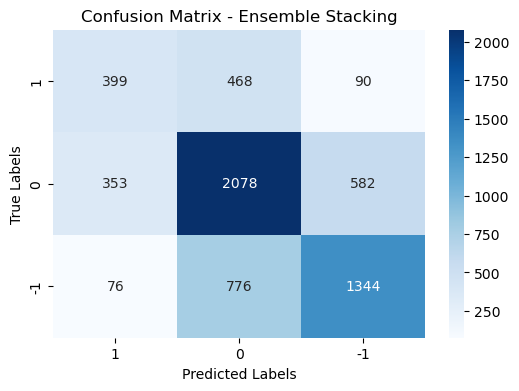

1 classified as 0: 468 times
1 classified as -1: 90 times
0 classified as 1: 353 times
0 classified as -1: 582 times
-1 classified as 1: 76 times
-1 classified as 0: 776 times



In [60]:
# Create a dictionary 'ensemble_classifiers' with keys as names of ensemble methods and values
# as their respective classifiers
ensemble_classifiers = {
    'Ensemble Voting': ensemble_voting_classifier,           # Ensemble Voting classifier
    'Weighted Majority Voting': weighted_voting_classifier,  # Weighted Majority Voting classifier
    'Ensemble Stacking': stacking_classifier                 # Ensemble Stacking classifier
}

# Call the function 'train_ensemble' to train and evaluate the ensemble classifiers on the validation data.
# The function will return the results and confusion matrices for each ensemble classifier.
count_ensemble_results, ensemble_confusion_matrices = ensemble_classification(
    ensemble_classifiers,              # Dictionary of ensemble classifiers
    count_train_oversampled,           # Training data (oversampled) for the ensemble classifiers
    count_labels_oversampled,          # Labels for the oversampled training data
    count_val_data,                # Development/validation data for evaluation
    y_val,                            # True labels for the development/validation data
    class_labels=[1, 0, -1]            # Class labels for plotting the confusion matrices
)

### Visualizing and Comparing Accuracy Results for Ensemble and Base Models Using Bar Plots

In [61]:
# The first two lines extract the accuracy values from the dictionaries count_results and count_ensemble_results and store
# them in separate lists count_model_accuracies and count_ensemble_accuracies, respectively. 
# The next two lines get the list of model names and ensemble names from the dictionaries and store them in count_models 
# and count_ensemble_names, respectively. 
# The line bar_colors = ['#1f77b4'] * len(count_models) + ['#ff7f0e'] * len(count_ensemble_names) creates
# a list of bar_colors with colors that will be used to visually distinguish between the bars for models and ensembles 
# in the bar chart. 
# The following block of code creates a DataFrame named count_df that combines the model and ensemble data
# along with their accuracy values and a label "Type" specifying whether it's a "Model" or an "Ensemble".
# The pd.DataFrame(data) call converts the data dictionary into a pandas DataFrame, count_df. The line, fig = px.bar(...) 
# creates the interactive bar chart using Plotly Express (px.bar). It specifies the DataFrame count_df as the data source, 
# the 'Model/Ensemble' column for the x-axis, the 'Accuracy' column for the y-axis, and the 'Type' column for color-coding 
# the bars. The parameters title, width, and height set the chart's title and the size of the plot in pixels.
# The color_discrete_map parameter sets the colors for each category (Model and Ensemble) to override the default colors 
# used by Plotly Express. Finally, fig.show() displays the interactive plot.



# Extract the accuracy values from the results dictionary
count_model_accuracies = [result['accuracy'] for result in count_results.values()]
count_ensemble_accuracies = [res['accuracy'] for res in count_ensemble_results.values()]

# Get the list of model names and ensemble names from the dictionaries
count_models = list(count_results.keys())
count_ensemble_names = list(count_ensemble_results.keys())

# Define visually pleasing colors for the bars
bar_colors = ['#1f77b4'] * len(count_models) + ['#ff7f0e'] * len(count_ensemble_names)

# Create a DataFrame with the data
data = {
    'Model/Ensemble': count_models + count_ensemble_names,
    'Accuracy': count_model_accuracies + count_ensemble_accuracies,
    'Type': ['Model'] * len(count_models) + ['Ensemble'] * len(count_ensemble_names)
}
count_df = pd.DataFrame(data)

# Sort the DataFrame based on accuracy values
count_df = count_df.sort_values(by='Accuracy', ascending=False)

# Create the interactive bar chart using Plotly Express
fig = px.bar(count_df, x='Model/Ensemble', y='Accuracy', color='Type',
             title='Model and Ensemble Accuracy Comparison',
             labels={'Accuracy': 'Accuracy Score', 'Model/Ensemble': 'Model/Ensemble Name'},
             width=800, height=500, color_discrete_map={'Model': '#1f77b4', 'Ensemble': '#ff7f0e'})

# Customize x-axis labels
fig.update_layout(xaxis_tickangle=-45)

# Place the legend outside the plot area
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

# Show the interactive plot
fig.show()

# Save the chart to an HTML file
fig.write_html("count2_accuracy_comparism.html")

### Visualizing and Comparing F1 Scores and Average Recall for Ensemble and Base models with Bar plots

In [62]:
# This code creates a bar chart to compare the F1 scores and average recall of individual models and ensemble models. 
# It extracts the F1 scores and average recall from the evaluation results of base models (count_results) 
# and ensemble models (count_ensemble_results). Then, it creates a DataFrame to organize the data, combining the names 
# of individual models and ensemble models with their corresponding F1 scores and average recall. Finally, it uses 
# Plotly Express to plot an interactive bar chart to visualize the comparison of F1 scores and average recall for the 
# different models and ensembles.

# Extract F1 scores and average recall from a dictionary of base models results
models_f1_scores = [result['f1_score'] for result in count_results.values()]
models_average_recall = [result['average_recall'] for result in count_results.values()]

# Extract a list of F1 scores from a dictionary of ensemble results.
ensemble_f1_scores = [result['f1_score'] for result in count_ensemble_results.values()]
# Extract a list of average recall scores from the same dictionary of ensemble results.
ensemble_average_recall = [result['average_recall'] for result in count_ensemble_results.values()]

# Create a list called 'count_models' containing the names of individual models.
count_models = list(count_results.keys())
# Create a list called 'count_ensemble_names' containing the names of ensemble models.
count_ensemble_names = list(count_ensemble_results.keys())

# Create a dictionary called 'data' with three key-value pairs.
data = {
    'Model/Ensemble': count_models + count_ensemble_names,
    'F1 Score': models_f1_scores + ensemble_f1_scores,
    'Average Recall': models_average_recall + ensemble_average_recall
}
# Create a DataFrame 'count_df' from the 'data' dictionary.
count_df = pd.DataFrame(data)
# Sort the DataFrame 'count_df' by 'F1 Score' and 'Average Recall' columns in descending order.
count_df = count_df.sort_values(by=['F1 Score','Average Recall'], ascending=False)


# Create a bar chart using Plotly Express ('px.bar').
# 'count_df' is the DataFrame containing the data.
# 'x' specifies the x-axis values from the 'Model/Ensemble' column.
# 'y' specifies the y-axis values, which are a list of two columns: 'F1 Score' and 'Average Recall'.
# 'barmode' is set to 'group' to group bars for each model/ensemble together.
# 'title' sets the title of the chart.
# 'width' and 'height' specify the dimensions of the chart.
fig = px.bar(count_df, x='Model/Ensemble', y=['F1 Score', 'Average Recall'], barmode='group',
             title='Model and Ensemble F1 Score and Average Recall Comparison', width=800, height=600)

# display the interactive plot
fig.show()

# Write the interactive plot as an HTML file named "count2_f1_recall_comparism.html".
fig.write_html("count2_f1_recall_comparism.html")

## Classification of Models Using TF-IDF Vectors

### Training and Transforming Training and Test Data into TF-IDF Vectors

In [63]:
# Create a TF-IDF vectorizer with a maximum of 10,000 features.
tfidf_vec = TfidfVectorizer(max_features=10000)

# Fit and transform the training data 'x_train' into TF-IDF vectors.
tfidf_train_data = tfidf_vec.fit_transform(x_train)

# Transform the validation data 'x_val' into TF-IDF vectors using the same vectorizer.
tfidf_val_data = tfidf_vec.transform(x_val)

# Transform the testing data 'testing_data' into TF-IDF vectors using the same vectorizer.
tfidf_test_data = tfidf_vec.transform(testing_data)

### Implementing the Mutual Information feature selection technique to reduce dimensionality.

In [64]:
# # Number of top features to select is 10000
# k_best = 10000

# #initialise mutual information using the select kbest function
# mi_selector = SelectKBest(score_func=mutual_info_classif, k=k_best)

# # Fit the selector on the train data and labels
# tfidf_train_selected = mi_selector.fit_transform(tfidf_train_data, training_labels)

# # Transform the testing data to include only the selected features
# tfidf_test_selected = mi_selector.transform(tfidf_test_data)

### Implementing Oversampling to handle data imbalance

In [65]:
# Create an instance of the SMOTE oversampler with specified parameters.
oversampler = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the training data to oversample the minority class.
# 'tfidf_train_data' represents the feature data, and 'y_train' is the corresponding target labels.
tfidf_train_oversampled, tfidf_labels_oversampled = oversampler.fit_resample(tfidf_train_data, y_train)

# Display the resulting oversampled training data.
tfidf_train_oversampled

<21858x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 248117 stored elements in Compressed Sparse Row format>

### Parameter tuning to obtain the best hyperparameters for the base models

In [67]:
# Call the 'get_best_params' function to obtain the best hyperparameters for machine learning models.
# The function takes as input 'models_list', 'param_dist', 'tfidf_train_oversampled', and 'tfidf_labels_oversampled'.

tfidf_best_params = get_best_params(models_list, param_dist, tfidf_train_oversampled, tfidf_labels_oversampled)

Performing RandomizedSearchCV for Logistic Regression
Best hyperparameters for Logistic Regression : {'C': 0.696850157946487, 'solver': 'newton-cg'}

Performing RandomizedSearchCV for SGD Classifier
Best hyperparameters for SGD Classifier : {'alpha': 0.0024286681792194077, 'loss': 'modified_huber', 'max_iter': 349}

Performing RandomizedSearchCV for Random Forest
Best hyperparameters for Random Forest : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 174}

Performing RandomizedSearchCV for Decision Tree
Best hyperparameters for Decision Tree : {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}

Performing RandomizedSearchCV for SVM
Best hyperparameters for SVM : {'kernel': 'rbf', 'gamma': 'scale', 'C': 10.0}



### Function to create a list of base models with best hyperparameters

In [68]:
# This code defines a function get_models that creates different machine learning models with the best hyperparameters
# obtained from a previous optimization process. The function returns a list of tuples where each tuple contains 
# the model's name and the corresponding instantiated model with the best hyperparameters.

def get_models(best_params):
    models = {}
    
    # Create a Logistic Regression model with the best hyperparameters (stored in best_params[0][2])
    models['Logistic Regression'] = LogisticRegression(**best_params[0][2])
    # Create an SGD Classifier model with the best hyperparameters (stored in best_params[1][2])
    models['SGD Classifier'] = SGDClassifier(**best_params[1][2])
    # Create a Random Forest model with the best hyperparameters (stored in best_params[3][2])
    models['Random Forest'] = RandomForestClassifier(**best_params[2][2])
    # Create a Decision Tree model with the best hyperparameters (stored in best_params[4][2])
    models['Decision Tree'] = DecisionTreeClassifier(**best_params[3][2])
    # Create an SVM (Support Vector Machine) model with the best hyperparameters (stored in best_params[5][2])
    models['SVM'] = SVC(**best_params[4][2])
    
    # Combine the model names and corresponding models into a list of tuples called estimators
    estimators = [(name, model) for name, model in models.items()]

    return estimators

### Validation of Base Models

In [69]:
# Create a list of machine learning models with their best hyperparameters based on 'tfidf_best_params'.
tfidf_models_with_best_params = get_models(tfidf_best_params)

# Perform validation for each model with their best hyperparameters on the oversampled TF-IDF data.
# Results are collected in 'tfidf_models_validation_results'.
tfidf_models_validation_results = [
    (name, perform_validation([(name, model)], tfidf_train_oversampled, tfidf_labels_oversampled))
    for name, model in tfidf_models_with_best_params
]

# Print a message indicating that the validation process is complete.
print("Validation Complete")

Training and evaluating Logistic Regression
Training and evaluating SGD Classifier
Training and evaluating Random Forest
Training and evaluating Decision Tree
Training and evaluating SVM
Validation Complete


### Normalization of F1 scores for utilization as model weights.

In [70]:
# The tfidf_normalized_f1_weights list will store the normalized weights utilized for the ensemble weighted voting. 
# These weights are designed to balance the influence of each model, aligning it with its performance 
# in terms of F1 score.

# Create an empty list to store mean F1 scores.
mean_f1_scores = []

# Iterate through the validation results for each model in 'tfidf_models_validation_results'.
for _, (accuracy_scores, f1_scores) in tfidf_models_validation_results:
    # Calculate the mean F1 score for the current model.
    mean_f1 = np.mean([score for _, scores in f1_scores for score in scores])
    # Append the mean F1 score to the 'mean_f1_scores' list.
    mean_f1_scores.append(mean_f1)


# Calculate the sum of all mean F1 scores.
sum_f1 = sum(mean_f1_scores)
# Calculate normalized F1 weights for each model based on their mean F1 scores.
tfidf_normalized_f1_weights = [f1 / sum_f1 for f1 in mean_f1_scores]
# Print the calculated normalized F1 weights.
print(tfidf_normalized_f1_weights)

[0.21046269378031845, 0.19508997247793616, 0.19713713900359567, 0.1585959063153741, 0.23871428842277567]


### Creating Ensemble Classifiers with Optimized Models

In [71]:
# Create an ensemble voting classifier using the list of models with their best parameters.
ensemble_voting_classifier = ensemble_voting(tfidf_models_with_best_params)

# Create an ensemble weighted voting classifier using the list of models with their best parameters
# and the normalized F1 weights calculated earlier.
weighted_voting_classifier = ensemble_weighted_voting(tfidf_models_with_best_params, tfidf_normalized_f1_weights)

# Create an ensemble stacking classifier using the list of models with their best parameters,
# and Logistic Regression as the meta-classifier with its best parameters.
stacking_classifier = ensemble_stacking(tfidf_models_with_best_params, LogisticRegression(**tfidf_best_params[0][2]))

### Validation of Ensemble Models

In [72]:
# Perform validation for the ensemble voting classifier and store the results in 'results_voting'.
results_voting = perform_validation([('ensemble Voting Classifier', ensemble_voting_classifier)],
                                    tfidf_train_oversampled, tfidf_labels_oversampled)

# Perform validation for the ensemble weighted voting classifier and store the results in 'results_weighted_voting'.
results_weighted_voting = perform_validation([('ensemble Weighted Voting Classifier', weighted_voting_classifier)],
                                            tfidf_train_oversampled, tfidf_labels_oversampled)

# Perform validation for the ensemble stacking classifier and store the results in 'results_stacking'.
results_stacking = perform_validation([('ensemble stacking Classifier', stacking_classifier)],
                                      tfidf_train_oversampled, tfidf_labels_oversampled)

# Print a message indicating that the validation process is complete.
print("Validation completed")

Training and evaluating ensemble Voting Classifier
Training and evaluating ensemble Weighted Voting Classifier
Training and evaluating ensemble stacking Classifier
Validation completed


### Aggregating and Analyzing Model Validation Results for TF-IDF Vectors

In [73]:
# Create an empty list to store all accuracy results for different models.
tfidf_all_results = []

# Iterate through the validation results for each model in 'tfidf_models_validation_results'.
for _, (accuracy_scores, f1_scores) in tfidf_models_validation_results:
    # Extract the accuracy scores for the current model and flatten the nested list.
    model_accuracies = [score for _, scores in accuracy_scores for score in scores]
    # Append the accuracy scores for the current model to 'tfidf_all_results'.
    tfidf_all_results.append(model_accuracies)

    

# Append the ensemble voting accuracies to the count_all_results list
tfidf_all_results.append(results_voting[0][0][1].tolist())
# Append the weighted voting accuracies to the count_all_results list
tfidf_all_results.append(results_weighted_voting[0][0][1].tolist())
# Append the ensemble stacking accuracies to the count_all_results list
tfidf_all_results.append(results_stacking[0][0][1].tolist())


# Combine the model names for plotting
# Use a list comprehension to extract the names from the tuples (name, model)
tfidf_all_names = [name for name, (accuracy_scores, f1_scores) in tfidf_models_validation_results]
# Append the names of the ensemble voting, weighted majority voting, and ensemble stacking classifiers to all_names
tfidf_all_names.append("Ensemble Voting")
tfidf_all_names.append("Weighted Majority Voting")
tfidf_all_names.append("Ensemble Stacking")


# Iterate through pairs of model names and their corresponding accuracy scores.
for name, scores in zip(tfidf_all_names, tfidf_all_results):
    # Calculate the mean accuracy score for the current model.
    tfidf_mean_score = np.mean(scores)
    # Calculate the standard deviation of accuracy scores for the current model.
    tfidf_std_score = np.std(scores)
    # Print the model name, mean accuracy, and standard deviation of accuracy.
    print(f"{name} - Mean_accuracy: {tfidf_mean_score:.3f} Std_accuracy: {tfidf_std_score:.3f}")
    # Print a separator line for clarity.
    print("------------------------------------")

Logistic Regression - Mean_accuracy: 0.733 Std_accuracy: 0.004
------------------------------------
SGD Classifier - Mean_accuracy: 0.681 Std_accuracy: 0.005
------------------------------------
Random Forest - Mean_accuracy: 0.683 Std_accuracy: 0.008
------------------------------------
Decision Tree - Mean_accuracy: 0.555 Std_accuracy: 0.009
------------------------------------
SVM - Mean_accuracy: 0.828 Std_accuracy: 0.008
------------------------------------
Ensemble Voting - Mean_accuracy: 0.741 Std_accuracy: 0.006
------------------------------------
Weighted Majority Voting - Mean_accuracy: 0.746 Std_accuracy: 0.005
------------------------------------
Ensemble Stacking - Mean_accuracy: 0.828 Std_accuracy: 0.006
------------------------------------


### Creating a Box Plot for Comparing Validation Accuracies of Models

In [74]:
# a list data is created to store the model names and their corresponding accuracies. This is done by iterating through 
# tfidf_all_names and tfidf_all_results simultaneously and creating dictionaries with the model name and 
# corresponding accuracy. The data list is then used to create a pandas DataFrame df. The 'Accuracy' column in df is 
# converted to numeric using pd.to_numeric to ensure that the data is in the correct format for calculations. 
# Mean and standard deviation scores are calculated for each model's results using groupby and mean() and std() functions, 
# respectively, and the results are stored in the mean_scores and std_scores DataFrames. Finally, an interactive box plot 
# is created using Plotly Express (px.box) to visualize and compare the accuracy distributions of different models and 
# ensembles. The 'Model/Ensemble' column is used as the x-axis, 'Accuracy' column as the y-axis, and 'all' points 
# are shown on the plot. The plot title is set to 'Model and Ensemble Accuracy Comparison'. 
# The interactive plot is then displayed using fig.show().



# Create a list to store the model names and corresponding accuracies
data = []
# loop through the list of tfidf_all_names and tfidf_all_results, and extract the names and accuracies
for name, accuracies in zip(tfidf_all_names, tfidf_all_results):
    # loop through each accuracy
    for accuracy in accuracies:
        # append each accuracy to the accuracy and name to the data list
        data.append({'Model/Ensemble': name, 'Accuracy': accuracy})

# Create the DataFrame with the data list
df = pd.DataFrame(data)

# Convert 'Accuracy' column to numeric
df['Accuracy'] = pd.to_numeric(df['Accuracy'], errors='coerce')

# Calculate the mean and standard deviation for each model's results
mean_scores = df.groupby('Model/Ensemble')['Accuracy'].mean().reset_index()
std_scores = df.groupby('Model/Ensemble')['Accuracy'].std().reset_index()

# Create the interactive box plot using Plotly Express
fig = px.box(df, x='Model/Ensemble', y='Accuracy', points='all', hover_data=['Model/Ensemble'],
             title='Model and Ensemble Accuracy Comparison', width=800, height=600)

# Show the interactive plot
fig.show()

### Function for classification and evaluation of base models

In [75]:
#The models_classification function takes a list of best_params_list containing the best hyperparameters for each 
#classifier, as well as the training and test data along with their corresponding labels. It trains each classifier 
# with the best hyperparameters on the training data, makes predictions on the test data, and evaluates the classifiers 
# using accuracy, f1-score, and average recall. It also generates the classification report and confusion matrix for 
# each classifier, and stores the evaluation results in a dictionary named results.The function then prints the 
# evaluation metrics and classification reports for each classifier, and plots a heatmap for each confusion matrix using 
# seaborn's heatmap function. It appends all the confusion matrices to the list, all_cms for later use. 
# Finally, the function returns two outputs as a tuple: the results dictionary containing the evaluation results for 
# each classifier, and the list all_cms containing all the confusion matrices.


def models_classification(best_params_list, train_data, train_labels, test_data, test_labels, class_labels):
    results = {}  # Initialize an empty dictionary to hold the evaluation results for each classifier
    all_cms = []  # List to store confusion matrices of all classifiers
    
    # Loop through the best_params_list containing tuples of (name, best_classifier, best_hyperparameters, _, _)
    for name, best_classifier, best_hyperparameters, _, _ in best_params_list:
        # Set the best_classifier as the classifier
        classifier = best_classifier
        
        # Set the best hyperparameters on the classifier
        classifier_with_params = classifier.set_params(**best_hyperparameters)
        
        # Print the classifier with the best hyperparameters
        print(classifier_with_params)
        
        # Train the classifier_with_params on the training data and labels
        classifier_with_params.fit(train_data, train_labels)
        
        # Make predictions on the test data using the trained classifier
        predicted_labels = classifier_with_params.predict(test_data)
        
        # Evaluate the performance of the classifier by calculating accuracy, f1-score, and average recall
        accuracy = accuracy_score(test_labels, predicted_labels)  # Calculate accuracy
        f1 = f1_score(test_labels, predicted_labels, average='macro')  # Calculate f1-score
        recall = recall_score(test_labels, predicted_labels, average='macro')  # Calculate average recall
        
        # Generate the classification report
        classification_rep = classification_report(test_labels, predicted_labels)
        
        # Print evaluation reports and classification reports for the current classifier
        print("Accuracy for {}: {:.3f}".format(name, accuracy))
        print("F1 Score for {}: {:.3f}".format(name, f1))
        print("Average Recall for {}: {:.3f}".format(name, recall))
        print("Classification Report for {}:".format(name))
        print(classification_rep)
        print()

        # Generate the confusion matrix using scikit-learn's confusion_matrix function
        cm = confusion_matrix(test_labels, predicted_labels)
        all_cms.append(cm)  # Append the confusion matrix to the list for later use

        # Plot the heatmap for the confusion matrix using seaborn's heatmap function
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix - {}'.format(name))
        plt.show()
        
        # Error analysis: Print instances of misclassification
        print(f'Analysing Classification Errors in:{name.upper()}')
        for i in range(len(class_labels)):
            for j in range(len(class_labels)):
                if i != j and cm[i, j] > 0:
                    print(f"{class_labels[i]} classified as {class_labels[j]}: {cm[i, j]} times")
        print()

        # Store the evaluation results (accuracy, f1-score, average recall, classification report, confusion matrix) 
        # in the dictionary
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'average_recall': recall,
            'classification_report': classification_rep,
            'confusion_matrix': cm
        }
    
    # Return the evaluation results dictionary and the list of confusion matrices as a tuple
    return results, all_cms

### Classification and Evaluation of Base Models

LogisticRegression(C=0.696850157946487, random_state=42, solver='newton-cg')
Accuracy for Logistic Regression: 0.645
F1 Score for Logistic Regression: 0.626
Average Recall for Logistic Regression: 0.642
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          -1       0.48      0.62      0.55       957
           0       0.69      0.64      0.66      3013
           1       0.68      0.66      0.67      2196

    accuracy                           0.64      6166
   macro avg       0.62      0.64      0.63      6166
weighted avg       0.65      0.64      0.65      6166




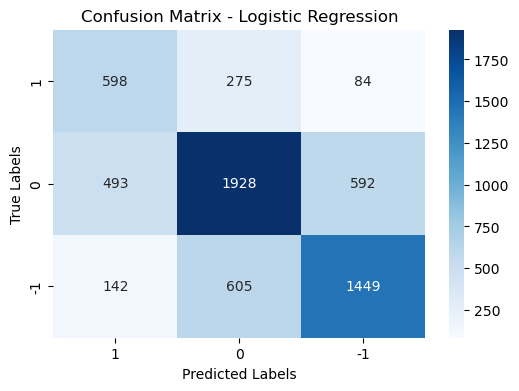

Analysing Classification Errors in:LOGISTIC REGRESSION
1 classified as 0: 275 times
1 classified as -1: 84 times
0 classified as 1: 493 times
0 classified as -1: 592 times
-1 classified as 1: 142 times
-1 classified as 0: 605 times

SGDClassifier(alpha=0.0024286681792194077, loss='modified_huber', max_iter=349,
              random_state=42)
Accuracy for SGD Classifier: 0.617
F1 Score for SGD Classifier: 0.602
Average Recall for SGD Classifier: 0.632
Classification Report for SGD Classifier:
              precision    recall  f1-score   support

          -1       0.43      0.66      0.52       957
           0       0.69      0.57      0.62      3013
           1       0.66      0.66      0.66      2196

    accuracy                           0.62      6166
   macro avg       0.59      0.63      0.60      6166
weighted avg       0.64      0.62      0.62      6166




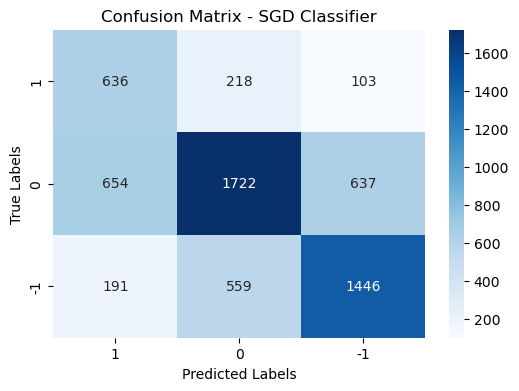

Analysing Classification Errors in:SGD CLASSIFIER
1 classified as 0: 218 times
1 classified as -1: 103 times
0 classified as 1: 654 times
0 classified as -1: 637 times
-1 classified as 1: 191 times
-1 classified as 0: 559 times

RandomForestClassifier(max_depth=20, min_samples_split=7, n_estimators=174,
                       random_state=42)
Accuracy for Random Forest: 0.603
F1 Score for Random Forest: 0.579
Average Recall for Random Forest: 0.581
Classification Report for Random Forest:
              precision    recall  f1-score   support

          -1       0.48      0.53      0.51       957
           0       0.62      0.68      0.65      3013
           1       0.65      0.53      0.59      2196

    accuracy                           0.60      6166
   macro avg       0.58      0.58      0.58      6166
weighted avg       0.61      0.60      0.60      6166




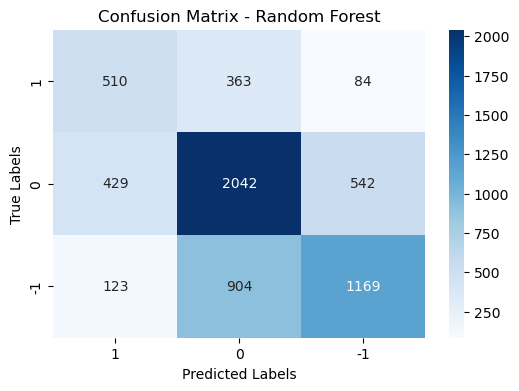

Analysing Classification Errors in:RANDOM FOREST
1 classified as 0: 363 times
1 classified as -1: 84 times
0 classified as 1: 429 times
0 classified as -1: 542 times
-1 classified as 1: 123 times
-1 classified as 0: 904 times

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=5,
                       random_state=42)
Accuracy for Decision Tree: 0.563
F1 Score for Decision Tree: 0.483
Average Recall for Decision Tree: 0.475
Classification Report for Decision Tree:
              precision    recall  f1-score   support

          -1       0.44      0.25      0.32       957
           0       0.56      0.80      0.66      3013
           1       0.64      0.37      0.47      2196

    accuracy                           0.56      6166
   macro avg       0.54      0.48      0.48      6166
weighted avg       0.57      0.56      0.54      6166




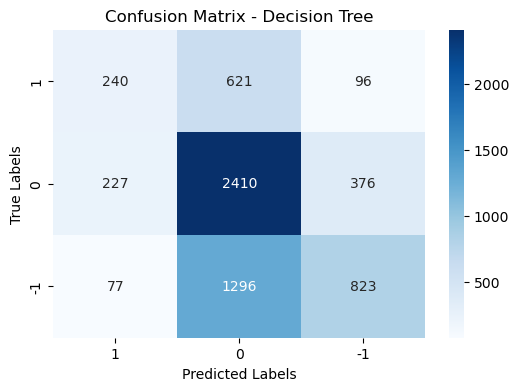

Analysing Classification Errors in:DECISION TREE
1 classified as 0: 621 times
1 classified as -1: 96 times
0 classified as 1: 227 times
0 classified as -1: 376 times
-1 classified as 1: 77 times
-1 classified as 0: 1296 times

SVC(C=10.0, random_state=42)
Accuracy for SVM: 0.655
F1 Score for SVM: 0.598
Average Recall for SVM: 0.576
Classification Report for SVM:
              precision    recall  f1-score   support

          -1       0.64      0.34      0.45       957
           0       0.63      0.81      0.71      3013
           1       0.72      0.58      0.64      2196

    accuracy                           0.65      6166
   macro avg       0.66      0.58      0.60      6166
weighted avg       0.66      0.65      0.64      6166




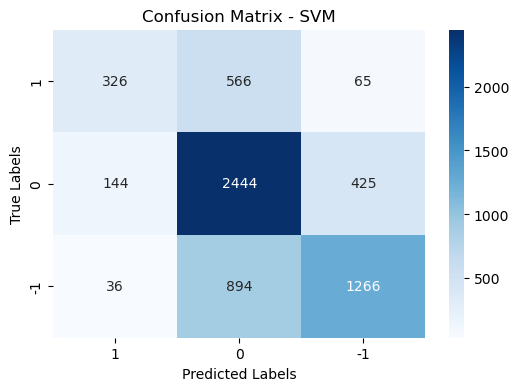

Analysing Classification Errors in:SVM
1 classified as 0: 566 times
1 classified as -1: 65 times
0 classified as 1: 144 times
0 classified as -1: 425 times
-1 classified as 1: 36 times
-1 classified as 0: 894 times



In [76]:
# Call the 'models_classification' function with appropriate parameters
# The function will train and evaluate the classifiers using the specified data
# and return the evaluation results and confusion matrices for each classifier
tfidf_models_classification, tfidf_cm = models_classification(
    tfidf_best_params,         # List of best hyperparameters for each classifier
    tfidf_train_oversampled,   # Training data (oversampled) for the classifiers
    tfidf_labels_oversampled,  # Labels for the oversampled training data
    tfidf_val_data,            # Development/validation data for evaluation
    y_val,                     # True labels for the development/validation data
    class_labels=[1, 0, -1]    # Class labels for plotting the confusion matrices
)

### Function for Classification and Evaluation of Ensemble Models

In [77]:
# The train_ensemble function takes a dictionary ensemble_classifiers containing the names and corresponding 
# ensemble classifiers as input. It then trains each classifier on the training data, makes predictions on the 
# validation data, calculates evaluation metrics (accuracy, f1-score, average recall), generates the classification report
# and confusion matrix, and stores the results in the ensemble_results dictionary. It also appends the confusion matrices 
# to the all_ensemble_cms list. Finally, it plots a heatmap for each confusion matrix and returns the evaluation results 
# and the list of confusion matrices as a tuple.

def ensemble_classification(ensemble_classifiers, train_data, train_labels, dev_data, dev_labels, class_labels):
    ensemble_results = {} # Initialize an empty dictionary to hold the evaluation results for each ensemble classifier
    all_ensemble_cms = [] # List to store confusion matrices of all ensemble classifiers
    
    # Loop through each ensemble classifier (name, classifier) in the dictionary ensemble_classifiers
    for name, classifier in ensemble_classifiers.items():
        # Train the classifier on the training data and labels
        classifier.fit(train_data, train_labels)
        
        # Make predictions on the validation data using the trained classifier
        predicted_labels = classifier.predict(dev_data)
        
        # Calculate accuracy, f1-score, and average recall for the classifier
        ensemble_accuracy = accuracy_score(dev_labels, predicted_labels) # Calculate accuracy
        ensemble_f1 = f1_score(dev_labels, predicted_labels, average='macro') # Calculate f1-score
        average_recall = recall_score(dev_labels, predicted_labels, average='macro') # Calculate average recall
        
        # Generate the classification report
        ensemble_report = classification_report(dev_labels, predicted_labels)
        
        # Generate the confusion matrix using scikit-learn's confusion_matrix function
        cm = confusion_matrix(dev_labels, predicted_labels)
        all_ensemble_cms.append(cm) # Append the confusion matrix to the list for later use
        
        # Store the evaluation results (accuracy, f1-score, average recall, classification report, confusion matrix) 
        # in the dictionary
        ensemble_results[name] = {
            'accuracy': ensemble_accuracy,
            'f1_score': ensemble_f1,
            'average_recall': average_recall,
            'classification_report': ensemble_report,
            'confusion_matrix': cm
        }
        
        # Print the evaluation results for the current classifier
        print(f"{name} Classifier Accuracy: {ensemble_accuracy:.3f}")
        print(f"{name} Classifier f1_score: {ensemble_f1:.3f}")
        print(f"{name} Classifier average_recall: {average_recall:.3f}")
        print(f"{name} Classifier Classification Report:")
        print(ensemble_report)
        print("------------------------------------")
        
        # Plot the heatmap for the confusion matrix using seaborn's heatmap function
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()
        
        # Error analysis
        print(f'Analysing Classification Errors in:{name.upper()}')
        for i in range(len(class_labels)):
            for j in range(len(class_labels)):
                if i != j and cm[i, j] > 0:
                    print(f"{class_labels[i]} classified as {class_labels[j]}: {cm[i, j]} times")
        print()
        
    # Return the evaluation results (ensemble_results) and the list of confusion matrices (all_ensemble_cms) as a tuple
    return ensemble_results, all_ensemble_cms

### Classification and Evaluation of ensemble models

Ensemble Voting Classifier Accuracy: 0.646
Ensemble Voting Classifier f1_score: 0.617
Ensemble Voting Classifier average_recall: 0.616
Ensemble Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.50      0.53      0.52       957
           0       0.65      0.71      0.68      3013
           1       0.71      0.61      0.66      2196

    accuracy                           0.65      6166
   macro avg       0.62      0.62      0.62      6166
weighted avg       0.65      0.65      0.65      6166

------------------------------------


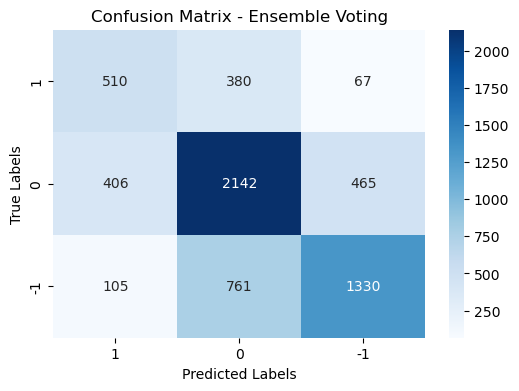

Analysing Classification Errors in:ENSEMBLE VOTING
1 classified as 0: 380 times
1 classified as -1: 67 times
0 classified as 1: 406 times
0 classified as -1: 465 times
-1 classified as 1: 105 times
-1 classified as 0: 761 times

Weighted Majority Voting Classifier Accuracy: 0.650
Weighted Majority Voting Classifier f1_score: 0.621
Weighted Majority Voting Classifier average_recall: 0.619
Weighted Majority Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.51      0.53      0.52       957
           0       0.66      0.72      0.68      3013
           1       0.71      0.61      0.66      2196

    accuracy                           0.65      6166
   macro avg       0.63      0.62      0.62      6166
weighted avg       0.65      0.65      0.65      6166

------------------------------------


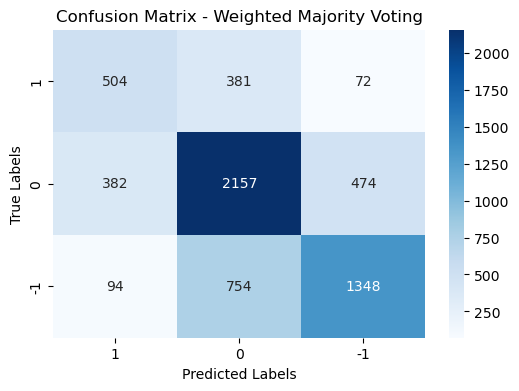

Analysing Classification Errors in:WEIGHTED MAJORITY VOTING
1 classified as 0: 381 times
1 classified as -1: 72 times
0 classified as 1: 382 times
0 classified as -1: 474 times
-1 classified as 1: 94 times
-1 classified as 0: 754 times

Ensemble Stacking Classifier Accuracy: 0.659
Ensemble Stacking Classifier f1_score: 0.610
Ensemble Stacking Classifier average_recall: 0.589
Ensemble Stacking Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.64      0.38      0.48       957
           0       0.63      0.80      0.71      3013
           1       0.72      0.59      0.65      2196

    accuracy                           0.66      6166
   macro avg       0.66      0.59      0.61      6166
weighted avg       0.67      0.66      0.65      6166

------------------------------------


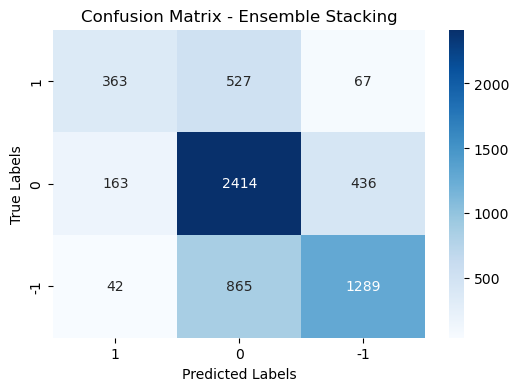

Analysing Classification Errors in:ENSEMBLE STACKING
1 classified as 0: 527 times
1 classified as -1: 67 times
0 classified as 1: 163 times
0 classified as -1: 436 times
-1 classified as 1: 42 times
-1 classified as 0: 865 times



In [78]:
# Define a dictionary 'ensemble_classifiers' that holds the ensemble classifiers to be evaluated.
# The keys represent the names of the ensemble classifiers, and the values are the corresponding classifier instances.

ensemble_classifiers = {
    'Ensemble Voting': ensemble_voting_classifier,
    'Weighted Majority Voting': weighted_voting_classifier,
    'Ensemble Stacking': stacking_classifier
}

# Call the function 'train_ensemble' to train and evaluate the ensemble classifiers on the validation data.
# The function will return the evaluation results and confusion matrices for each ensemble classifier.
tfidf_ensemble_results, ensemble_confusion_matrices = ensemble_classification(
    ensemble_classifiers,        # Dictionary of ensemble classifiers
    tfidf_train_oversampled,     # Training data (oversampled) for the ensemble classifiers
    tfidf_labels_oversampled,    # Labels for the oversampled training data
    tfidf_val_data,              # Development/validation data for evaluation
    y_val,                       # True labels for the development/validation data
    class_labels=[1, 0, -1]      # Class labels for plotting the confusion matrices
)

### Visualizing and Comparing Accuracy of All Models Using Plotly Bar Charts

In [79]:
# Extract the accuracy values from the results dictionaries for models and ensembles
# 'tfidf_models_results' and 'tfidf_ensemble_results' are dictionaries containing the evaluation results of 
# individual models and ensembles, respectively, obtained from the previous evaluation process.
# The 'accuracy' key in each result dictionary corresponds to the accuracy score of the model or ensemble.
# 'model_accuracies' is a list that stores the accuracy scores of individual models, obtained from 'tfidf_models_results'.
# 'ensemble_accuracies' is a list that stores the accuracy scores of ensemble classifiers, 
# obtained from 'tfidf_ensemble_results'.


# Extract the accuracy values from the results dictionaries for models and ensembles
model_accuracies = [result['accuracy'] for result in tfidf_models_classification.values()]
ensemble_accuracies = [res['accuracy'] for res in tfidf_ensemble_results.values()]

# Extract the keys (models names) from the results dictionaries for models and ensembles
models = list(tfidf_models_classification.keys())
ensemble_names = list(tfidf_ensemble_results.keys())

# Define visually pleasing colors for the bars
bar_colors = ['#1f77b4'] * len(models) + ['#ff7f0e'] * len(ensemble_names)

# Create a dictionary to structure the data for creating a DataFrame.
data = {
    # Define a column 'Model/Ensemble' and populate it with model names followed by ensemble names.
    'Model/Ensemble': models + ensemble_names,
    # Define a column 'Accuracy' and populate it with model accuracies followed by ensemble accuracies.
    'Accuracy': model_accuracies + ensemble_accuracies,
    # Define a column 'Type' and populate it with 'Model' for individual models and 'Ensemble' for ensemble models.
    'Type': ['Model'] * len(models) + ['Ensemble'] * len(ensemble_names)
}


# convert Data dict to dataframe using pd.DataFrame()
tfidf_df = pd.DataFrame(data)

# Sort the DataFrame based on accuracy values in descending order
tfidf_df = tfidf_df.sort_values(by='Accuracy', ascending=False)


# Create a bar chart using Plotly Express (px).
fig = px.bar(
    tfidf_df,                    # DataFrame containing the data.
    x='Model/Ensemble',          # Specify the x-axis as 'Model/Ensemble' column.
    y='Accuracy',                # Specify the y-axis as 'Accuracy' column.
    color='Type',                # Color the bars based on the 'Type' column (Model or Ensemble).
    title='Model and Ensemble Accuracy Comparison',  # Set the title of the chart.
    labels={'Accuracy': 'Accuracy Score', 'Model/Ensemble': 'Model/Ensemble Name'},  # Set axis labels.
    width=800,                   # Set the width of the chart.
    height=500,                  # Set the height of the chart.
    color_discrete_map={'Model': '#1f77b4', 'Ensemble': '#ff7f0e'}  # Define custom colors for Model and Ensemble bars.
)

# Customize x-axis labels
fig.update_layout(xaxis_tickangle=-45)

# Place the legend outside the plot area
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

# Show the interactive plot
fig.show()

# Save the chart to an HTML file
fig.write_html("tfidf3_accuracy_comparism.html")

### Visualizing and Comparing F1 Scores and Average Recall for All Models

In [80]:
# The code extracts relevant data from the provided dictionaries, organizes it in a DataFrame, 
# and visualizes the F1 scores and average recall values for different models and ensembles using an interactive bar chart. 
# The user can interact with the chart to explore the data and compare the performance of different models and ensembles.

# Extract F1 scores and average recall values from dictionaries and store them in separate lists.
# Extract F1 scores for individual models from 'tfidf_models_classification' dictionary.
models_f1_scores = [result['f1_score'] for result in tfidf_models_classification.values()]
# Extract average recall values for individual models from 'tfidf_models_classification' dictionary.
models_average_recall = [result['average_recall'] for result in tfidf_models_classification.values()]
# Extract F1 scores for ensemble models from 'tfidf_ensemble_results' dictionary.
ensemble_f1_scores = [result['f1_score'] for result in tfidf_ensemble_results.values()]
# Extract average recall values for ensemble models from 'tfidf_ensemble_results' dictionary.
ensemble_average_recall = [result['average_recall'] for result in tfidf_ensemble_results.values()]


# Create lists of model names and ensemble names based on dictionary keys.
# Create a list 'models' containing model names from 'tfidf_models_classification' dictionary.
models = list(tfidf_models_classification.keys())
# Create a list 'ensemble_names' containing ensemble names from 'tfidf_ensemble_results' dictionary.
ensemble_names = list(tfidf_ensemble_results.keys())


# Create a dictionary to structure the data for creating a DataFrame.
data = {
    # Define a column 'Model/Ensemble' and populate it with model names followed by ensemble names.
    'Model/Ensemble': models + ensemble_names,
    # Define a column 'F1 Score' and populate it with model F1 scores followed by ensemble F1 scores.
    'F1 Score': models_f1_scores + ensemble_f1_scores,
    # Define a column 'Average Recall' and populate it with model average recall scores
    # followed by ensemble average recall scores.
    'Average Recall': models_average_recall + ensemble_average_recall
}


# Create a Pandas DataFrame 'df' using the structured data from the 'data' dictionary.
df = pd.DataFrame(data)

# Sort the DataFrame 'df' based on the columns 'F1 Score' and 'Average Recall' in descending order.
df = df.sort_values(by=['F1 Score', 'Average Recall'], ascending=False)

# Create the interactive bar chart using Plotly Express
fig = px.bar(df, x='Model/Ensemble', y=['F1 Score', 'Average Recall'], barmode='group',
             title='Model and Ensemble F1 Score and Average Recall Comparison', width=800, height=600)

# Show the interactive plot
fig.show()

# Save the chart to an HTML file
fig.write_html("tfidf3_f1_recall_comparism2.html")

## Classifying Models Using Pretrained Google Word2Vec Vectors

### Transforming training data

In [81]:
# This code aims to compute Word2Vec representations for tokenized training tweets. If a word is found in the Word2Vec 
# model's vocabulary, its vector is directly added to the tweet's vector. If not, it tries to use character 
# n-grams (2-grams and 3-grams) to find embeddings for the word. If any n-grams are found and added to the word's vector, 
# the tweet's vector is updated with the mean of these embeddings. If no n-grams are found, the word is considered 
# Out-of-Vocabulary (OOV), and the count of OOV words is incremented. The final tweet vectors are then normalized by 
# dividing by the count to get the mean of the embeddings for each tweet. The OOV count is printed at the end.



# Function to tokenize a single tweet
def tokenize_tweet(tweet):
    tokens = word_tokenize(tweet)
    return tokens

# Apply tokenization to the training data
tokenized_tweets = x_train.apply(tokenize_tweet)

# Path to the w2v pretrained model file
file_path = 'C:/Users/ritac/Documents/Datasets/GoogleNews-vectors-negative300.bin.gz'

# Load the w2v pretrained model
model = KeyedVectors.load_word2vec_format(file_path, binary=True)

# Retrieve w2v model vocabularies
vocab_keys = model.key_to_index.keys()

# Setting the vector dimension
vector_dimension = model.vector_size

# Initializing an empty vector list
w2v_train_vectors = []

# Initialize a counter for out-of-vocabulary words
oov_count = 0

# Initialize a list to store OOV words
oov_words = []

# Set the value of n for character n-grams
n = 3  

# Looping through the training data
for tweet in tokenized_tweets:
    # Initialize an empty tweet vector
    tweet_vector = np.zeros(vector_dimension)
    count = 0
    
    # Iterate through the words in the tweet
    for w in tweet:
        # Check if the word is in the Word2Vec model's vocabulary
        if w in vocab_keys:
            # If found, add the word vector to the tweet vector
            tweet_vector += model[w]
            count += 1
        else:
            # Handle words not in the vocabulary using character n-grams
            
            # Generate 3-grams for the word 'w'
            #word_ngrams_3 = [w[i:i+n] for i in range(len(w)-n+1)]
            # Generate 2-grams for the word 'w'
            #word_ngrams_2 = [w[i:i+2] for i in range(len(w)-1)]
            
            # Initialize a vector to store the sum of embeddings of n-grams
            word_vector = np.zeros(vector_dimension)
            
            # Iterate through the 3-grams and check if they are in the Word2Vec model's vocabulary
            #for ngram in word_ngrams_3:
                #if ngram in model:
                    #If found, add the n-gram vector to the word vector
                    #word_vector += model[ngram]
                    #count += 1
                    
            # Iterate through the 2-grams and check if they are in the Word2Vec model's vocabulary
            #for n_gram in word_ngrams_2:
                #if n_gram in model:
                    #If found, add the 2-gram vector to the word vector
                    #word_vector += model[n_gram]
                    #count += 1
    
            # If any character n-grams were found and added to the word's vector, 
            # normalize the vector by dividing by the count
            if count > 0:
                word_vector /= count
                # Update the tweet vector with the mean of these embeddings
                tweet_vector += word_vector
            else:
                # Handle OOV words with no character n-gram matches
                # print(f"({w}) is an OOV word")
                oov_count += 1
                # Append OOV word to the list
                oov_words.append(w)
    
    # Normalize the tweet vector by dividing by the count to get the mean of the embeddings
    if count > 0:
        tweet_vector /= count
    
    # Add the tweet's vector to the list of Word2Vec vectors for the training data
    w2v_train_vectors.append(tweet_vector)

# Print the total number of out-of-vocabulary words
print("Total out-of-vocabulary words: {}".format(oov_count))

Total out-of-vocabulary words: 904


### Transforming Validation Data

In [82]:
# This code aims to compute Word2Vec representations for tokenized validation/dev tweets. If a word is found in the 
# Word2Vec model's vocabulary, its vector is directly added to the tweet's vector. If not, it tries to use character 
# n-grams (2-grams and 3-grams) to find embeddings for the word. If any n-grams are found and added to the word's vector, 
# the tweet's vector is updated with the mean of these embeddings. If no n-grams are found, the word is considered 
# Out-of-Vocabulary (OOV), and the count of OOV words is incremented. The final tweet vectors are then normalized by 
# dividing by the count to get the mean of the embeddings for each tweet. The OOV count is printed at the end.



# Tokenize the test data
tokenized_dev_tweets = x_val.apply(tokenize_tweet)

# Initialize an empty vector list for the Word2Vec vectors of the test data
w2v_dev_vectors = []

# Initialize a counter for out-of-vocabulary words
dev_oov_count = 0

# Initialize a list to store OOV words
dev_oov_words = []

# Loop through the tokenized test tweets and compute the Word2Vec vectors
for tweet in tokenized_dev_tweets:
    # Initialize a vector with zeros to represent the tweet's vector
    tweet_vector = np.zeros(vector_dimension)
    # Initialize a count to keep track of the number of words/n-grams found in the Word2Vec model
    count = 0
    
    # Loop through each word in the tokenized tweet
    for w in tweet:
        # Check if the word is in the vocabulary (Word2Vec model)
        if w in vocab_keys:
            # If the word is in the vocabulary, add its vector to the tweet's vector and increment the count
            tweet_vector += model[w]
            count += 1
        else:
            # If the word is not in the vocabulary, attempt to use character n-grams to find embeddings for the word
            # Extract 2-grams and 3-grams from the word
            
            #word_ngrams_3 = [w[i:i+n] for i in range(len(w)-n+1)]
            #word_ngrams_2 = [w[i:i+2] for i in range(len(w)-1)]
            
            # Initialize a vector for the word's representation using character n-grams
            word_vector = np.zeros(vector_dimension)
            
            # Loop through 3-grams and add their vectors if available in the Word2Vec model
            #for ngram in word_ngrams_3:
                #if ngram in model:
                    #word_vector += model[ngram]
                    #count += 1
            # Loop through 2-grams and add their vectors if available in the Word2Vec model
            #for n_gram in word_ngrams_2:
                #if n_gram in model:
                    #word_vector += model[n_gram]
                    #count += 1
                    
            # If any character n-grams were found and added to the word's vector, 
            # normalize the vector by dividing by the count
            if count > 0:
                word_vector /= count
                tweet_vector += word_vector
            else:
                # If the word has no character n-gram matches in the Word2Vec model, handle it as an OOV word
                dev_oov_count += 1
                # Append the OOV word to the list
                dev_oov_words.append(w)
    
    # Normalize the tweet vector by dividing by the count to get the mean of the embeddings
    if count > 0:
        tweet_vector /= count
    
    # Add the tweet's vector to the list of Word2Vec vectors for the test data
    w2v_dev_vectors.append(tweet_vector)
    
    
# Print the total number of out-of-vocabulary words
print("Total out-of-vocabulary words: {}".format(dev_oov_count))

Total out-of-vocabulary words: 372


### Transforming the Final test Data

In [83]:
# This code aims to compute Word2Vec representations for tokenized validation/dev tweets. If a word is found in the 
# Word2Vec model's vocabulary, its vector is directly added to the tweet's vector. If not, it tries to use character 
# n-grams (2-grams and 3-grams) to find embeddings for the word. If any n-grams are found and added to the word's vector, 
# the tweet's vector is updated with the mean of these embeddings. If no n-grams are found, the word is considered 
# Out-of-Vocabulary (OOV), and the count of OOV words is incremented. The final tweet vectors are then normalized by 
# dividing by the count to get the mean of the embeddings for each tweet. The OOV count is printed at the end.



# Tokenize the test data
tokenized_testing_tweets = testing_data.apply(tokenize_tweet)

# Initialize an empty vector list for the Word2Vec vectors of the test data
w2v_testing_vectors = []

# Initialize a counter for out-of-vocabulary words
testing_oov_count = 0

# Initialize a list to store OOV words
testing_oov_words = []

# Loop through the tokenized test tweets and compute the Word2Vec vectors
for tweet in tokenized_testing_tweets:
    # Initialize a vector with zeros to represent the tweet's vector
    tweet_vector = np.zeros(vector_dimension)
    # Initialize a count to keep track of the number of words/n-grams found in the Word2Vec model
    count = 0
    
    # Loop through each word in the tokenized tweet
    for w in tweet:
        # Check if the word is in the vocabulary (Word2Vec model)
        if w in vocab_keys:
            # If the word is in the vocabulary, add its vector to the tweet's vector and increment the count
            tweet_vector += model[w]
            count += 1
        else:
            # If the word is not in the vocabulary, attempt to use character n-grams to find embeddings for the word
            # Extract 2-grams and 3-grams from the word
            
            #word_ngrams_3 = [w[i:i+n] for i in range(len(w)-n+1)]
            #word_ngrams_2 = [w[i:i+2] for i in range(len(w)-1)]
            
            # Initialize a vector for the word's representation using character n-grams
            word_vector = np.zeros(vector_dimension)
            
            # Loop through 3-grams and add their vectors if available in the Word2Vec model
            #for ngram in word_ngrams_3:
                #if ngram in model:
                    #word_vector += model[ngram]
                    #count += 1
            # Loop through 2-grams and add their vectors if available in the Word2Vec model
            #for n_gram in word_ngrams_2:
                #if n_gram in model:
                    #word_vector += model[n_gram]
                    #count += 1
                    
            # If any character n-grams were found and added to the word's vector, 
            # normalize the vector by dividing by the count
            if count > 0:
                word_vector /= count
                tweet_vector += word_vector
            else:
                # If the word has no character n-gram matches in the Word2Vec model, handle it as an OOV word
                testing_oov_count += 1
                # Append the OOV word to the list
                testing_oov_words.append(w)
    
    # Normalize the tweet vector by dividing by the count to get the mean of the embeddings
    if count > 0:
        tweet_vector /= count
    
    # Add the tweet's vector to the list of Word2Vec vectors for the test data
    w2v_testing_vectors.append(tweet_vector)
    
    
# Print the total number of out-of-vocabulary words
print("Total out-of-vocabulary words: {}".format(testing_oov_count))

Total out-of-vocabulary words: 758


###  Converting  Vectors to NumPy array

In [84]:
# Convert w2v_train_vectors to a NumPy array
w2v_train_data = np.array(w2v_train_vectors)

# Convert the training labels (y_train) to a NumPy array
w2v_label = np.array(y_train)

# Convert w2v_dev_vectors to a NumPy array for validation data
w2v_val_data = np.array(w2v_dev_vectors)

# Convert w2v_testing_vectors to a NumPy array for test data
w2v_test_data = np.array(w2v_testing_vectors)

### Applying Oversampling to Word2Vec Training Vectors for Addressing Data Imbalance

In [85]:
# Create an instance of the SMOTE (Synthetic Minority Over-sampling Technique) oversampling method 
# with a specified random state.
smote = SMOTE(random_state=42)

# Apply SMOTE to oversample the training data and labels, creating new synthetic samples for the minority class.
w2v_train_oversampled, w2v_labels_oversampled = smote.fit_resample(w2v_train_data, w2v_label)

### Hyperparameter Tuning for Word2Vec-Based Models

In [86]:
# Use the parameter tuning function to obtain the best hyperparameters for models using the 
# oversampled Word2Vec training data and labels.
w2v_best_params = get_best_params(models_list, param_dist, w2v_train_oversampled, w2v_labels_oversampled)

Performing RandomizedSearchCV for Logistic Regression
Best hyperparameters for Logistic Regression : {'C': 0.696850157946487, 'solver': 'newton-cg'}

Performing RandomizedSearchCV for SGD Classifier
Best hyperparameters for SGD Classifier : {'alpha': 0.0024286681792194077, 'loss': 'modified_huber', 'max_iter': 349}

Performing RandomizedSearchCV for Random Forest
Best hyperparameters for Random Forest : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 174}

Performing RandomizedSearchCV for Decision Tree
Best hyperparameters for Decision Tree : {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}

Performing RandomizedSearchCV for SVM
Best hyperparameters for SVM : {'kernel': 'rbf', 'gamma': 'scale', 'C': 10.0}



### Creating Machine Learning Models with Optimized Hyperparameters

In [87]:
# This code defines a function get_models that creates different machine learning models with the best hyperparameters
# obtained from a previous optimization process. The function returns a list of tuples where each tuple contains 
# the model's name and the corresponding instantiated model with the best hyperparameters.

def get_models(best_params):
    models = {}
    
    # Create a Logistic Regression model with the best hyperparameters (stored in best_params[0][2])
    models['Logistic Regression'] = LogisticRegression(**best_params[0][2])
    # Create an SGD Classifier model with the best hyperparameters (stored in best_params[1][2])
    models['SGD Classifier'] = SGDClassifier(**best_params[1][2])
    # Create a Random Forest model with the best hyperparameters (stored in best_params[2][2])
    models['Random Forest'] = RandomForestClassifier(**best_params[2][2])
    # Create a Decision Tree model with the best hyperparameters (stored in best_params[3][2])
    models['Decision Tree'] = DecisionTreeClassifier(**best_params[3][2])
    # Create an SVM (Support Vector Machine) model with the best hyperparameters (stored in best_params[4][2])
    models['SVM'] = SVC(**best_params[4][2])
    
    # Combine the model names and corresponding models into a list of tuples called estimators
    estimators = [(name, model) for name, model in models.items()]

    return estimators

### Model Validation and Performance Assessment with Optimized Hyperparameters

In [88]:
# Create a list of machine learning models with the best hyperparameters using the function get_models 
# and the obtained w2v_best_params.
w2v_models_with_best_params = get_models(w2v_best_params)

# Perform validation for each model in w2v_models_with_best_params on the oversampled Word2Vec training data and labels.
# The results are stored as a list of tuples containing the model's name and its validation results.
w2v_results_models = [
    (name, perform_validation([(name, model)], w2v_train_oversampled, w2v_labels_oversampled))
    for name, model in w2v_models_with_best_params]

# Print a message to indicate that the validation process is complete.
print("Validation Complete")

Training and evaluating Logistic Regression
Training and evaluating SGD Classifier
Training and evaluating Random Forest
Training and evaluating Decision Tree
Training and evaluating SVM
Validation Complete


### Calculating Normalized F1 Weights for Weighted Ensemble Voting

In [89]:
# this code calculates the normalized F1 weights for weighted ensemble voting by first 
# computing the mean F1 score for each model. The weights are normalized to ensure that each model's 
# contribution to the ensemble is proportional to its performance in terms of the F1 score. 
# The resulting normalized weights are printed to the console.


# Initialize an empty list to store mean F1 scores for each model.
mean_f1_scores = []

# Iterate over the results of each model's validation.
for _, (accuracy_scores, f1_scores) in w2v_results_models:
    # Calculate the mean F1 score for each model.
    mean_f1 = np.mean([score for _, scores in f1_scores for score in scores])
    # Append the mean F1 score to the mean_f1_scores list.
    mean_f1_scores.append(mean_f1)

# Calculate the sum of all mean F1 scores.
sum_f1 = sum(mean_f1_scores)

# Calculate the normalized F1 weights by dividing each mean F1 score by the sum of all mean F1 scores.
w2v_normalized_f1_scores = [f1 / sum_f1 for f1 in mean_f1_scores]

# Print the normalized F1 weights.
print(w2v_normalized_f1_scores)

[0.18934152979006996, 0.18741275267496735, 0.22137108619519918, 0.1702765937315829, 0.23159803760818057]


### Creating Ensemble Classifiers with Optimized Models

In [90]:
# Create an ensemble voting classifier using the models with best hyperparameters.
ensemble_voting_classifier = ensemble_voting(w2v_models_with_best_params)

# Create a weighted ensemble voting classifier using the models with best hyperparameters 
# and normalized F1 scores as weights.
weighted_voting_classifier = ensemble_weighted_voting(w2v_models_with_best_params, w2v_normalized_f1_scores)

# Create an ensemble stacking classifier using the models with best hyperparameters 
# and a logistic regression meta-classifier.
stacking_classifier = ensemble_stacking(w2v_models_with_best_params, LogisticRegression(**w2v_best_params[0][2]))

### Evaluating Ensemble Classifier Performance on Oversampled Data

In [91]:
# Perform validation for the ensemble voting classifier using the oversampled Word2Vec training data and labels.
w2v_results_voting = perform_validation(
    [('ensemble Voting Classifier', ensemble_voting_classifier)], w2v_train_oversampled, w2v_labels_oversampled)

# Perform validation for the weighted ensemble voting classifier using the oversampled Word2Vec training data and labels.
w2v_results_weighted_voting = perform_validation([('ensemble Weighted Voting Classifier', weighted_voting_classifier)],
                                             w2v_train_oversampled, w2v_labels_oversampled)

# Perform validation for the ensemble stacking classifier using the oversampled Word2Vec training data and labels.
w2v_results_stacking = perform_validation([('ensemble stacking Classifier', stacking_classifier)],
                                       w2v_train_oversampled, w2v_labels_oversampled)

# Print a message to indicate that the validation process is completed.
print("Validation completed")

Training and evaluating ensemble Voting Classifier
Training and evaluating ensemble Weighted Voting Classifier
Training and evaluating ensemble stacking Classifier
Validation completed


### Aggregating and Analyzing Model Validation Results for Word2Vec Vectors

In [92]:
# this code collects and summarizes the validation results of various classifiers, including ensemble methods, 
# and provides insights into their performance by printing mean accuracy and standard deviation values

# Initialize an empty list to store validation results.
w2v_all_results = []

# Iterate over the validation results for different models.
for _, (accuracy_scores, f1_scores) in w2v_results_models:
    # Extract the accuracy scores and flatten the nested list structure.
    model_accuracies = [score for _, scores in accuracy_scores for score in scores]
    # Append the accuracy scores to the w2v_all_results list.
    w2v_all_results.append(model_accuracies)

# Append the accuracy scores of the ensemble voting classifier to w2v_all_results.
w2v_all_results.append(w2v_results_voting[0][0][1].tolist())

# Append the accuracy scores of the weighted majority voting classifier to w2v_all_results.
w2v_all_results.append(w2v_results_weighted_voting[0][0][1].tolist())

# Append the accuracy scores of the ensemble stacking classifier to w2v_all_results.
w2v_all_results.append(w2v_results_stacking[0][0][1].tolist())

# Create a list of model names by extracting names from w2v_results_models.
w2v_all_names = [name for name, (accuracy_scores, f1_scores) in w2v_results_models]

# Add names for the ensemble voting, weighted majority voting, and ensemble stacking classifiers to w2v_all_names.
w2v_all_names.append("Ensemble Voting")
w2v_all_names.append("Weighted Majority Voting")
w2v_all_names.append("Ensemble Stacking")

# Iterate over model names and corresponding accuracy scores.
for name, scores in zip(w2v_all_names, w2v_all_results):
    # Calculate the mean accuracy and standard deviation.
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    # Print the results including model name, mean accuracy, and standard deviation.
    print(f"{name} - Mean_accuracy: {mean_score:.3f} Std_accuracy: {std_score:.3f}")
    print("------------------------------------")

Logistic Regression - Mean_accuracy: 0.659 Std_accuracy: 0.004
------------------------------------
SGD Classifier - Mean_accuracy: 0.654 Std_accuracy: 0.005
------------------------------------
Random Forest - Mean_accuracy: 0.771 Std_accuracy: 0.004
------------------------------------
Decision Tree - Mean_accuracy: 0.595 Std_accuracy: 0.011
------------------------------------
SVM - Mean_accuracy: 0.808 Std_accuracy: 0.004
------------------------------------
Ensemble Voting - Mean_accuracy: 0.752 Std_accuracy: 0.004
------------------------------------
Weighted Majority Voting - Mean_accuracy: 0.763 Std_accuracy: 0.001
------------------------------------
Ensemble Stacking - Mean_accuracy: 0.817 Std_accuracy: 0.004
------------------------------------


### Visualizing and Comparing Model and Ensemble Validation Accuracy Using a Box Plot

In [93]:
# a list data is created to store the model names and their corresponding accuracies. This is done by iterating through 
# tfidf_all_names and tfidf_all_results simultaneously and creating dictionaries with the model name and 
# corresponding accuracy. The data list is then used to create a pandas DataFrame df. The 'Accuracy' column in df is 
# converted to numeric using pd.to_numeric to ensure that the data is in the correct format for calculations. 
# Mean and standard deviation scores are calculated for each model's results using groupby and mean() and std() functions, 
# respectively, and the results are stored in the mean_scores and std_scores DataFrames. Finally, an interactive box plot 
# is created using Plotly Express (px.box) to visualize and compare the accuracy distributions of different models and 
# ensembles. The 'Model/Ensemble' column is used as the x-axis, 'Accuracy' column as the y-axis, and 'all' points 
# are shown on the plot. The plot title is set to 'Model and Ensemble Accuracy Comparison'. 
# The interactive plot is then displayed using fig.show().



# Initialize an empty list to store data.
data = []

# Iterate over model names and their corresponding accuracy scores.
for name, accuracies in zip(w2v_all_names, w2v_all_results):
    # Iterate over individual accuracy scores.
    for accuracy in accuracies:
        # Append data as a dictionary with model name and accuracy.
        data.append({'Model/Ensemble': name, 'Accuracy': accuracy})

# Create a DataFrame from the collected data.
df = pd.DataFrame(data)

# Convert the 'Accuracy' column to numeric, handling errors by coercing to NaN.
df['Accuracy'] = pd.to_numeric(df['Accuracy'], errors='coerce')

# Calculate the mean accuracy scores for each model/ensemble.
mean_scores = df.groupby('Model/Ensemble')['Accuracy'].mean().reset_index()
# Calculate the standard deviation of accuracy scores for each model/ensemble.
std_scores = df.groupby('Model/Ensemble')['Accuracy'].std().reset_index()

# Create the interactive box plot using Plotly Express
fig = px.box(df, x='Model/Ensemble', y='Accuracy', points='all', hover_data=['Model/Ensemble'],
             title='Model and Ensemble Accuracy Comparison', width=800, height=600)

# Show the interactive plot
fig.show()

# Save the chart to an HTML file
fig.write_html("w2v_validation_accuracy_comparism2.html")

### Function for Classification and Evaluation of Base Models 

In [94]:
#The models_classification function takes a list of best_params_list containing the best hyperparameters for each 
#classifier, as well as the training and test data along with their corresponding labels. It trains each classifier 
# with the best hyperparameters on the training data, makes predictions on the test data, and evaluates the classifiers 
# using accuracy, f1-score, and average recall. It also generates the classification report and confusion matrix for 
# each classifier, and stores the evaluation results in a dictionary named results.The function then prints the 
# evaluation metrics and classification reports for each classifier, and plots a heatmap for each confusion matrix using 
# seaborn's heatmap function. It appends all the confusion matrices to the list, all_cms for later use. 
# Finally, the function returns two outputs as a tuple: the results dictionary containing the evaluation results for 
# each classifier, and the list all_cms containing all the confusion matrices.


def models_classification(best_params_list, train_data, train_labels, test_data, test_labels, class_labels):
    results = {}  # Initialize an empty dictionary to hold the evaluation results for each classifier
    all_cms = []  # List to store confusion matrices of all classifiers
    
    # Loop through the best_params_list containing tuples of (name, best_classifier, best_hyperparameters, _, _)
    for name, best_classifier, best_hyperparameters, _, _ in best_params_list:
        # Set the best_classifier as the classifier
        classifier = best_classifier
        
        # Set the best hyperparameters on the classifier
        classifier_with_params = classifier.set_params(**best_hyperparameters)
        
        # Print the classifier with the best hyperparameters
        print(classifier_with_params)
        
        # Train the classifier_with_params on the training data and labels
        classifier_with_params.fit(train_data, train_labels)
        
        # Make predictions on the test data using the trained classifier
        predicted_labels = classifier_with_params.predict(test_data)
        
        # Evaluate the performance of the classifier by calculating accuracy, f1-score, and average recall
        accuracy = accuracy_score(test_labels, predicted_labels)  # Calculate accuracy
        f1 = f1_score(test_labels, predicted_labels, average='macro')  # Calculate f1-score
        recall = recall_score(test_labels, predicted_labels, average='macro')  # Calculate average recall
        
        # Generate the classification report
        classification_rep = classification_report(test_labels, predicted_labels)
        
        # Print evaluation reports and classification reports for the current classifier
        print("Accuracy for {}: {:.3f}".format(name, accuracy))
        print("F1 Score for {}: {:.3f}".format(name, f1))
        print("Average Recall for {}: {:.3f}".format(name, recall))
        print("Classification Report for {}:".format(name))
        print(classification_rep)
        print()

        # Generate the confusion matrix using scikit-learn's confusion_matrix function
        cm = confusion_matrix(test_labels, predicted_labels)
        all_cms.append(cm)  # Append the confusion matrix to the list for later use

        # Plot the heatmap for the confusion matrix using seaborn's heatmap function
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix - {}'.format(name))
        plt.show()

        # Store the evaluation results (accuracy, f1-score, average recall, classification report, confusion matrix) 
        # in the dictionary
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'average_recall': recall,
            'classification_report': classification_rep,
            'confusion_matrix': cm
        }
        
        # Error analysis: Print instances of misclassification
        print(f'Analysing Classification Errors in:{name.upper()}')
        for i in range(len(class_labels)):
            for j in range(len(class_labels)):
                if i != j and cm[i, j] > 0:
                    print(f"{class_labels[i]} classified as {class_labels[j]}: {cm[i, j]} times")
        print()
    
    # Return the evaluation results dictionary and the list of confusion matrices as a tuple
    return results, all_cms

### Classification and Evaluation of Base Models

LogisticRegression(C=0.696850157946487, random_state=42, solver='newton-cg')
Accuracy for Logistic Regression: 0.615
F1 Score for Logistic Regression: 0.602
Average Recall for Logistic Regression: 0.633
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          -1       0.43      0.68      0.53       957
           0       0.69      0.56      0.62      3013
           1       0.66      0.66      0.66      2196

    accuracy                           0.61      6166
   macro avg       0.59      0.63      0.60      6166
weighted avg       0.64      0.61      0.62      6166




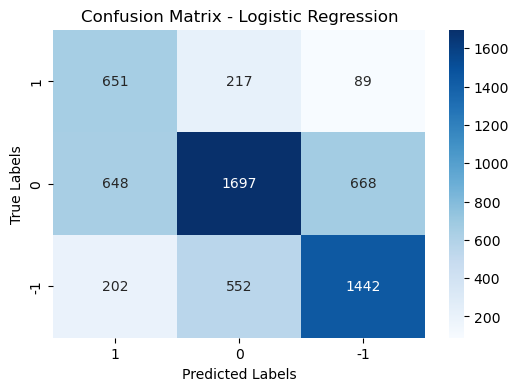

Analysing Classification Errors in:LOGISTIC REGRESSION
1 classified as 0: 217 times
1 classified as -1: 89 times
0 classified as 1: 648 times
0 classified as -1: 668 times
-1 classified as 1: 202 times
-1 classified as 0: 552 times

SGDClassifier(alpha=0.0024286681792194077, loss='modified_huber', max_iter=349,
              random_state=42)
Accuracy for SGD Classifier: 0.609
F1 Score for SGD Classifier: 0.597
Average Recall for SGD Classifier: 0.634
Classification Report for SGD Classifier:
              precision    recall  f1-score   support

          -1       0.42      0.71      0.52       957
           0       0.69      0.56      0.62      3013
           1       0.66      0.64      0.65      2196

    accuracy                           0.61      6166
   macro avg       0.59      0.63      0.60      6166
weighted avg       0.64      0.61      0.61      6166




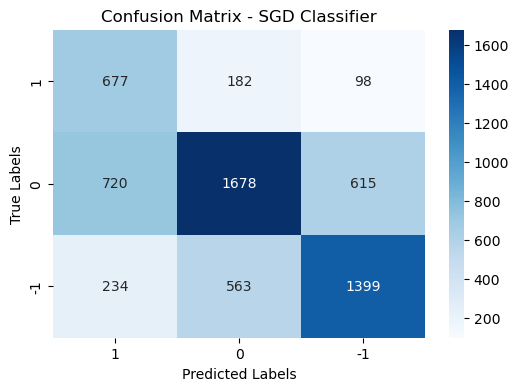

Analysing Classification Errors in:SGD CLASSIFIER
1 classified as 0: 182 times
1 classified as -1: 98 times
0 classified as 1: 720 times
0 classified as -1: 615 times
-1 classified as 1: 234 times
-1 classified as 0: 563 times

RandomForestClassifier(max_depth=20, min_samples_split=7, n_estimators=174,
                       random_state=42)
Accuracy for Random Forest: 0.603
F1 Score for Random Forest: 0.572
Average Recall for Random Forest: 0.567
Classification Report for Random Forest:
              precision    recall  f1-score   support

          -1       0.49      0.47      0.48       957
           0       0.61      0.69      0.65      3013
           1       0.64      0.54      0.58      2196

    accuracy                           0.60      6166
   macro avg       0.58      0.57      0.57      6166
weighted avg       0.60      0.60      0.60      6166




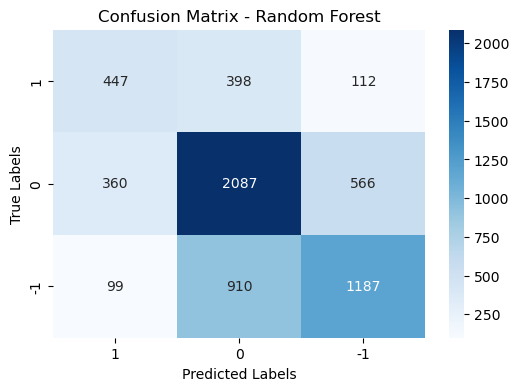

Analysing Classification Errors in:RANDOM FOREST
1 classified as 0: 398 times
1 classified as -1: 112 times
0 classified as 1: 360 times
0 classified as -1: 566 times
-1 classified as 1: 99 times
-1 classified as 0: 910 times

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=5,
                       random_state=42)
Accuracy for Decision Tree: 0.449
F1 Score for Decision Tree: 0.424
Average Recall for Decision Tree: 0.436
Classification Report for Decision Tree:
              precision    recall  f1-score   support

          -1       0.27      0.39      0.32       957
           0       0.54      0.46      0.50      3013
           1       0.46      0.45      0.45      2196

    accuracy                           0.45      6166
   macro avg       0.42      0.44      0.42      6166
weighted avg       0.47      0.45      0.45      6166




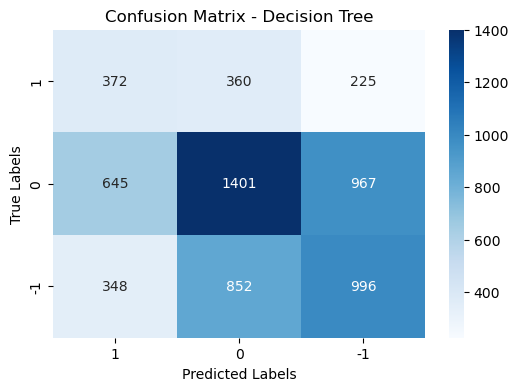

Analysing Classification Errors in:DECISION TREE
1 classified as 0: 360 times
1 classified as -1: 225 times
0 classified as 1: 645 times
0 classified as -1: 967 times
-1 classified as 1: 348 times
-1 classified as 0: 852 times

SVC(C=10.0, random_state=42)
Accuracy for SVM: 0.639
F1 Score for SVM: 0.608
Average Recall for SVM: 0.601
Classification Report for SVM:
              precision    recall  f1-score   support

          -1       0.54      0.48      0.51       957
           0       0.65      0.71      0.68      3013
           1       0.67      0.61      0.64      2196

    accuracy                           0.64      6166
   macro avg       0.62      0.60      0.61      6166
weighted avg       0.64      0.64      0.64      6166




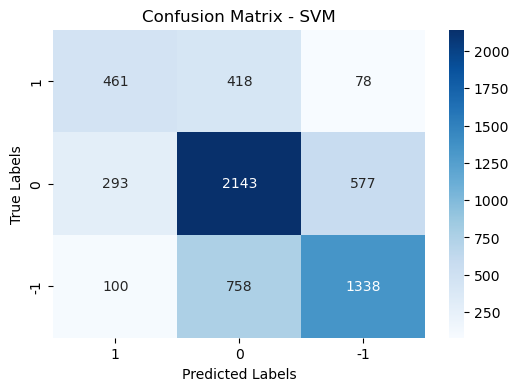

Analysing Classification Errors in:SVM
1 classified as 0: 418 times
1 classified as -1: 78 times
0 classified as 1: 293 times
0 classified as -1: 577 times
-1 classified as 1: 100 times
-1 classified as 0: 758 times



In [95]:
# Call the 'base models_classification' function with appropriate parameters
# The function will train and evaluate the classifiers using the specified data
# and return the evaluation results and confusion matrices for each classifier
w2v_models_results, w2v_cm = models_classification(
    w2v_best_params,         # List of best hyperparameters for each classifier
    w2v_train_oversampled,   # Training data (oversampled) for the classifiers
    w2v_labels_oversampled,  # Labels for the oversampled training data
    w2v_val_data,            # Development/validation data for evaluation
    y_val,                     # True labels for the development/validation data
    class_labels=[1, 0, -1]    # Class labels for plotting the confusion matrices
)

### Function for Classification and Evaluation of Ensemble Models

In [96]:
# The train_ensemble function takes a dictionary ensemble_classifiers containing the names and corresponding 
# ensemble classifiers as input. It then trains each classifier on the training data, makes predictions on the 
# validation data, calculates evaluation metrics (accuracy, f1-score, average recall), generates the classification report
# and confusion matrix, and stores the results in the ensemble_results dictionary. It also appends the confusion matrices 
# to the all_ensemble_cms list. Finally, it plots a heatmap for each confusion matrix and returns the evaluation results 
# and the list of confusion matrices as a tuple.

def ensemble_classification(ensemble_classifiers, train_data, train_labels, dev_data, dev_labels, class_labels):
    ensemble_results = {} # Initialize an empty dictionary to hold the evaluation results for each ensemble classifier
    all_ensemble_cms = [] # List to store confusion matrices of all ensemble classifiers
    
    # Loop through each ensemble classifier (name, classifier) in the dictionary ensemble_classifiers
    for name, classifier in ensemble_classifiers.items():
        # Train the classifier on the training data and labels
        classifier.fit(train_data, train_labels)
        
        # Make predictions on the validation data using the trained classifier
        predicted_labels = classifier.predict(dev_data)
        
        # Calculate accuracy, f1-score, and average recall for the classifier
        ensemble_accuracy = accuracy_score(dev_labels, predicted_labels) # Calculate accuracy
        ensemble_f1 = f1_score(dev_labels, predicted_labels, average='macro') # Calculate f1-score
        average_recall = recall_score(dev_labels, predicted_labels, average='macro') # Calculate average recall
        
        # Generate the classification report
        ensemble_report = classification_report(dev_labels, predicted_labels)
        
        # Generate the confusion matrix using scikit-learn's confusion_matrix function
        cm = confusion_matrix(dev_labels, predicted_labels)
        all_ensemble_cms.append(cm) # Append the confusion matrix to the list for later use
        
        # Store the evaluation results (accuracy, f1-score, average recall, classification report, confusion matrix) 
        # in the dictionary
        ensemble_results[name] = {
            'accuracy': ensemble_accuracy,
            'f1_score': ensemble_f1,
            'average_recall': average_recall,
            'classification_report': ensemble_report,
            'confusion_matrix': cm
        }
        
        # Print the evaluation results for the current classifier
        print(f"{name} Classifier Accuracy: {ensemble_accuracy:.3f}")
        print(f"{name} Classifier f1_score: {ensemble_f1:.3f}")
        print(f"{name} Classifier average_recall: {average_recall:.3f}")
        print(f"{name} Classifier Classification Report:")
        print(ensemble_report)
        print("------------------------------------")
        
        # Plot the heatmap for the confusion matrix using seaborn's heatmap function
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()
        
        # Error analysis: Print instances of misclassification
        print(f'Analysing Classification Errors in:{name.upper()}')
        for i in range(len(class_labels)):
            for j in range(len(class_labels)):
                if i != j and cm[i, j] > 0:
                    print(f"{class_labels[i]} classified as {class_labels[j]}: {cm[i, j]} times")
        print()
        
    # Return the evaluation results (ensemble_results) and the list of confusion matrices (all_ensemble_cms) as a tuple
    return ensemble_results, all_ensemble_cms

### Classification and Evaluation of Ensemble Models

Ensemble Voting Classifier Accuracy: 0.626
Ensemble Voting Classifier f1_score: 0.609
Ensemble Voting Classifier average_recall: 0.630
Ensemble Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.45      0.64      0.53       957
           0       0.68      0.62      0.65      3013
           1       0.67      0.63      0.65      2196

    accuracy                           0.63      6166
   macro avg       0.60      0.63      0.61      6166
weighted avg       0.64      0.63      0.63      6166

------------------------------------


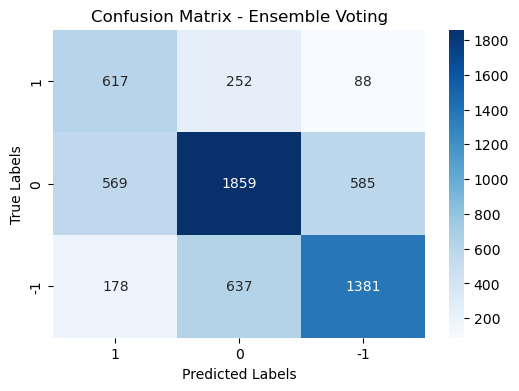

Analysing Classification Errors in:ENSEMBLE VOTING
1 classified as 0: 252 times
1 classified as -1: 88 times
0 classified as 1: 569 times
0 classified as -1: 585 times
-1 classified as 1: 178 times
-1 classified as 0: 637 times

Weighted Majority Voting Classifier Accuracy: 0.633
Weighted Majority Voting Classifier f1_score: 0.614
Weighted Majority Voting Classifier average_recall: 0.627
Weighted Majority Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.48      0.60      0.53       957
           0       0.67      0.64      0.65      3013
           1       0.67      0.64      0.65      2196

    accuracy                           0.63      6166
   macro avg       0.61      0.63      0.61      6166
weighted avg       0.64      0.63      0.64      6166

------------------------------------


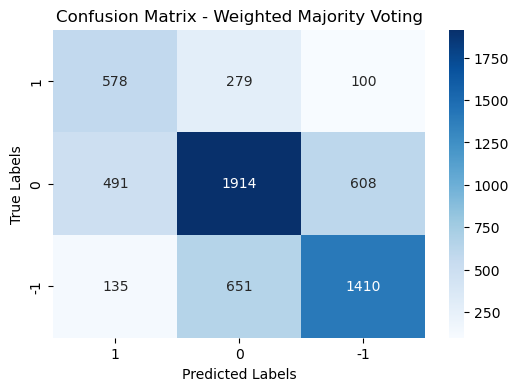

Analysing Classification Errors in:WEIGHTED MAJORITY VOTING
1 classified as 0: 279 times
1 classified as -1: 100 times
0 classified as 1: 491 times
0 classified as -1: 608 times
-1 classified as 1: 135 times
-1 classified as 0: 651 times

Ensemble Stacking Classifier Accuracy: 0.651
Ensemble Stacking Classifier f1_score: 0.605
Ensemble Stacking Classifier average_recall: 0.588
Ensemble Stacking Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.59      0.40      0.47       957
           0       0.64      0.78      0.70      3013
           1       0.70      0.59      0.64      2196

    accuracy                           0.65      6166
   macro avg       0.64      0.59      0.60      6166
weighted avg       0.65      0.65      0.64      6166

------------------------------------


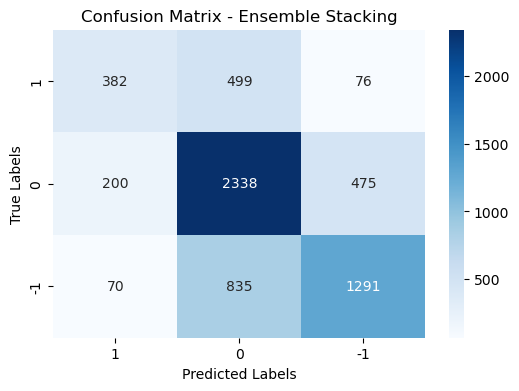

Analysing Classification Errors in:ENSEMBLE STACKING
1 classified as 0: 499 times
1 classified as -1: 76 times
0 classified as 1: 200 times
0 classified as -1: 475 times
-1 classified as 1: 70 times
-1 classified as 0: 835 times



In [97]:
# Define a dictionary 'ensemble_classifiers' that holds the ensemble classifiers to be evaluated.
# The keys represent the names of the ensemble classifiers, and the values are the corresponding classifier instances.

ensemble_classifiers = {
    'Ensemble Voting': ensemble_voting_classifier,
    'Weighted Majority Voting': weighted_voting_classifier,
    'Ensemble Stacking': stacking_classifier
}

# Call the function 'train_ensemble' to train and evaluate the ensemble classifiers on the validation data.
# The function will return the evaluation results and confusion matrices for each ensemble classifier.
w2v_ensemble_results = ensemble_classification(
    ensemble_classifiers,        # Dictionary of ensemble classifiers
    w2v_train_oversampled,     # Training data (oversampled) for the ensemble classifiers
    w2v_labels_oversampled,          # Labels for the oversampled training data
    w2v_val_data,              # Development/validation data for evaluation
    y_val,                       # True labels for the development/validation data
    class_labels=[1, 0, -1]      # Class labels for plotting the confusion matrices
)

### Creating a Bar Plot for Model and Ensemble Accuracy Comparison"

In [98]:
# Extract the accuracy values from the results dictionaries for models and ensembles.
# 'w2v_ensemble_results' is a list containing dictionaries with ensemble evaluation results.
# Here, we access the first dictionary (index 0) from the list to extract ensemble results.
w2v_ensemble_results_dict = w2v_ensemble_results[0]
# Extract individual model accuracy scores from the 'w2v_models_results' dictionary.
# 'w2v_models_results' is a dictionary where keys are model names, and values are dictionaries 
# containing evaluation results.
# We use a list comprehension to extract the 'accuracy' value from each model's result dictionary.
model_accuracies = [result['accuracy'] for result in w2v_models_results.values()]
# Extract ensemble classifier accuracy scores from the 'w2v_ensemble_results_dict' dictionary.
# Similar to the previous line, we use a list comprehension to extract 'accuracy' values 
# from the ensemble results dictionary.
ensemble_accuracies = [res['accuracy'] for res in w2v_ensemble_results_dict.values()]

# Create a list of individual model names by extracting keys from the 'w2v_models_results' dictionary.
models = list(w2v_models_results.keys())
# Create a list of ensemble classifier names by extracting keys from the 'w2v_ensemble_results_dict' dictionary.
ensemble_names = list(w2v_ensemble_results_dict.keys())

# Define visually pleasing colors for the bars
bar_colors = ['#1f77b4'] * len(models) + ['#ff7f0e'] * len(ensemble_names)


# Create a dictionary 'data' to organize model and ensemble data for creating a DataFrame.
# 'models' contains individual model names, 'ensemble_names' contains ensemble classifier names,
# 'model_accuracies' contains individual model accuracy scores, and 'ensemble_accuracies' 
# contains ensemble classifier accuracy scores.
data = {
    # Combine model and ensemble names into one list.
    'Model/Ensemble': models + ensemble_names,
    # Combine model and ensemble accuracy scores into one list.
    'Accuracy': model_accuracies + ensemble_accuracies,
    # Assign 'Model' or 'Ensemble' label to each data point.
    'Type': ['Model'] * len(models) + ['Ensemble'] * len(ensemble_names)  
}


# Create a DataFrame 'w2v_df' using the 'data' dictionary.
w2v_df = pd.DataFrame(data)

# Sort the 'w2v_df' DataFrame by the 'Accuracy' column in descending order (highest accuracy first).
w2v_df = w2v_df.sort_values(by='Accuracy', ascending=False)


# Create the interactive bar chart using Plotly Express
fig = px.bar(w2v_df, x='Model/Ensemble', y='Accuracy', color='Type',
             title='Model and Ensemble Accuracy Comparison',
             labels={'Accuracy': 'Accuracy Score', 'Model/Ensemble': 'Model/Ensemble Name'},
             width=800, height=500, color_discrete_map={'Model': '#1f77b4', 'Ensemble': '#ff7f0e'})

# Customize x-axis labels
fig.update_layout(xaxis_tickangle=-45)

# Place the legend outside the plot area
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

# Show the interactive plot
fig.show()

# Save the chart to an HTML file
fig.write_html("w2v3_accuracy_comparism.html")

### Visualising and Comparing all Models' F1 Scores and Average Recalls using Plotly Group Bar Chart

In [99]:
# The code extracts relevant data from the provided dictionaries, organizes it in a DataFrame, 
# and visualizes the F1 scores and average recall values for different models and ensembles using an interactive bar chart. 
# The user can interact with the chart to explore the data and compare the performance of different models and ensembles.

# Extract ensemble results dictionary from the list of results
w2v_ensemble_results_dict = w2v_ensemble_results[0]
# Extract F1 scores of individual models from the models' results dictionary
models_f1_scores = [result['f1_score'] for result in w2v_models_results.values()]
# Extract average recall scores of individual models from the models' results dictionary
models_average_recall = [result['average_recall'] for result in w2v_models_results.values()]
# Extract F1 scores of ensemble classifiers from the ensemble results dictionary
ensemble_f1_scores = [result['f1_score'] for result in w2v_ensemble_results_dict.values()]
# Extract average recall scores of ensemble classifiers from the ensemble results dictionary
ensemble_average_recall = [result['average_recall'] for result in w2v_ensemble_results_dict.values()]


# Extract the keys (models names) from the results dictionaries for models and ensembles
w2v_models = list(w2v_models_results.keys())
w2v_ensemble_names = list(w2v_ensemble_results_dict.keys())

# Create a dictionary to store data for constructing a DataFrame
data = {
    'Model/Ensemble': w2v_models + w2v_ensemble_names,  # Combine model and ensemble names
    'F1 Score': models_f1_scores + ensemble_f1_scores,    # Combine F1 scores of models and ensembles
    'Average Recall': models_average_recall + ensemble_average_recall  # Combine average recall scores
}

# create a dataframe with data dictionary
df = pd.DataFrame(data)

# Sort the DataFrame 'df' by two columns, 'F1 Score' and 'Average Recall', in descending order
df = df.sort_values(by=['F1 Score', 'Average Recall'], ascending=False)

# Create the interactive bar chart using Plotly Express
fig = px.bar(df, x='Model/Ensemble', y=['F1 Score', 'Average Recall'], barmode='group',
             title='Model and Ensemble F1 Score and Average Recall Comparison', width=800, height=600)

# Show the interactive plot
fig.show()

# Save the chart to an HTML file
fig.write_html("w2v3_f1_recall_comparism.html2")

### Final Testing with Best Classifier Based on Average Recall Using the SemEval Test Data

Ensemble Voting Classifier Accuracy: 0.616
Ensemble Voting Classifier f1_score: 0.603
Ensemble Voting Classifier average_recall: 0.598
Ensemble Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.58      0.69      0.63      3811
           0       0.64      0.62      0.63      5743
           1       0.63      0.48      0.55      2352

    accuracy                           0.62     11906
   macro avg       0.62      0.60      0.60     11906
weighted avg       0.62      0.62      0.61     11906

------------------------------------


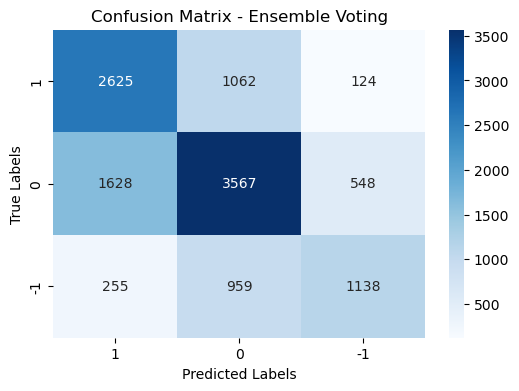

Analysing Classification Errors in:ENSEMBLE VOTING
1 classified as 0: 1062 times
1 classified as -1: 124 times
0 classified as 1: 1628 times
0 classified as -1: 548 times
-1 classified as 1: 255 times
-1 classified as 0: 959 times

Weighted Majority Voting Classifier Accuracy: 0.620
Weighted Majority Voting Classifier f1_score: 0.604
Weighted Majority Voting Classifier average_recall: 0.594
Weighted Majority Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.61      0.63      0.62      3811
           0       0.62      0.67      0.65      5743
           1       0.64      0.48      0.55      2352

    accuracy                           0.62     11906
   macro avg       0.62      0.59      0.60     11906
weighted avg       0.62      0.62      0.62     11906

------------------------------------


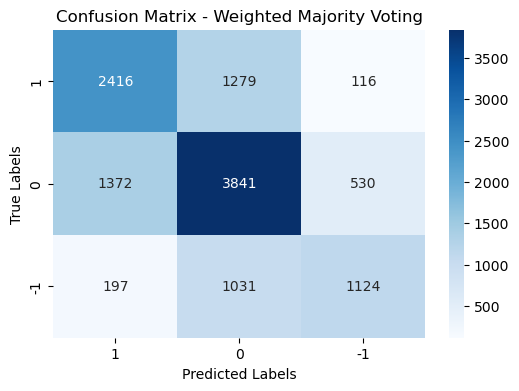

Analysing Classification Errors in:WEIGHTED MAJORITY VOTING
1 classified as 0: 1279 times
1 classified as -1: 116 times
0 classified as 1: 1372 times
0 classified as -1: 530 times
-1 classified as 1: 197 times
-1 classified as 0: 1031 times

Ensemble Stacking Classifier Accuracy: 0.599
Ensemble Stacking Classifier f1_score: 0.539
Ensemble Stacking Classifier average_recall: 0.525
Ensemble Stacking Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.73      0.32      0.45      3811
           0       0.56      0.87      0.68      5743
           1       0.66      0.38      0.49      2352

    accuracy                           0.60     11906
   macro avg       0.65      0.53      0.54     11906
weighted avg       0.64      0.60      0.57     11906

------------------------------------


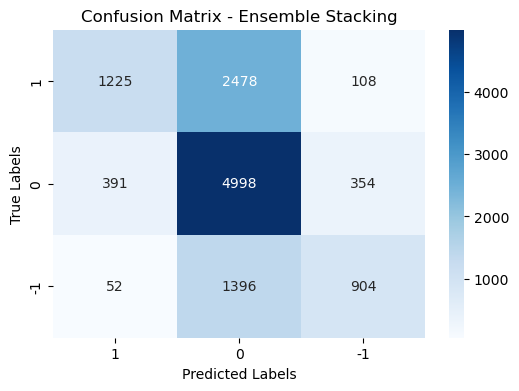

Analysing Classification Errors in:ENSEMBLE STACKING
1 classified as 0: 2478 times
1 classified as -1: 108 times
0 classified as 1: 391 times
0 classified as -1: 354 times
-1 classified as 1: 52 times
-1 classified as 0: 1396 times



In [105]:
# Call the function 'train_ensemble' to train and evaluate the ensemble classifiers on the validation data.
# The function will return the evaluation results and confusion matrices for each ensemble classifier.
final_w2v_ensemble_results = ensemble_classification(
    ensemble_classifiers,        # Dictionary of ensemble classifiers
    w2v_train_oversampled,     # Training data (oversampled) for the ensemble classifiers
    w2v_labels_oversampled,          # Labels for the oversampled training data
    w2v_test_data,              # Development/validation data for evaluation
    testing_labels,                       # True labels for the development/validation data
    class_labels=[1, 0, -1]      # Class labels for plotting the confusion matrices
)

# Visual Comparison of Base and Ensemble Classifier Performance Across Feature Extraction Techniques

### Accuracy comparison of Base and Ensemble Classifiers

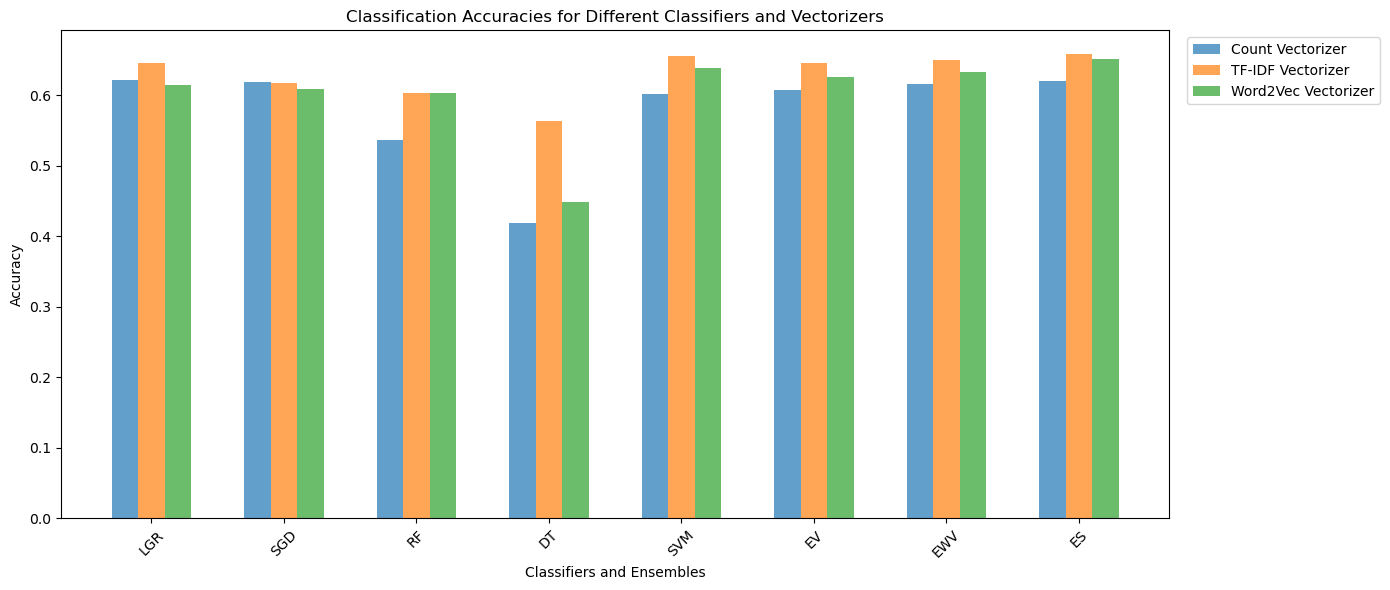

In [108]:
# This code generates a grouped bar chart using matplotlib to visualize the mean validation accuracies 
# of a set of classifiers (both base models and ensemble classifiers) across three different text vectorization 
# techniques (Count Vectorizer, TF-IDF Vectorizer, Word2Vec Vectorizer). The chart helps compare and visualize how these 
# classifiers (logistic regression-LGR, STOCHASTIC GRADIENT DESCENT (SGD), RANDOM FOREST(RF), DECISION TREE(DT), 
# SUPPORT VECTOR MACHINE(SVM), ENSEMBLE VOTING(EV), ENSEMBLE WEIGHTED VOTING(EWV), ENSEMBLE STACKING (ES), 
# perform under different vectorization methods.


# Define the classifiers and their mean accuracies for each vectorizer
classifiers = ["LGR", "SGD", "RF", "DT", "SVM", "EV", "EWV","ES"]
count_accuracies = [0.621, 0.618, 0.536, 0.419, 0.602, 0.608, 0.616, 0.620]    # accuracies for count vectorizer
tfidf_accuracies = [0.645, 0.617, 0.603, 0.563, 0.655, 0.646, 0.650, 0.659]     # accuracies for TF-IDF vectorizer
word2vec_accuracies = [0.615, 0.609, 0.603, 0.449, 0.639, 0.626, 0.633, 0.651]   # accuracies for Word2Vec vectorizer

# Set the width of each bar in the bar chart
bar_width = 0.2

# Calculate the x-axis positions for each group of bars
index = np.arange(len(classifiers))  # Create an array of indices for the classifiers/ensembles

# Create the grouped bar chart
plt.figure(figsize=(14, 6))  # Create a figure object with a specific size for the plot
# Create bars for Count Vectorizer
plt.bar(index - bar_width, count_accuracies, bar_width, label='Count Vectorizer', alpha=0.7)
# Create bars for TF-IDF Vectorizer
plt.bar(index, tfidf_accuracies, bar_width, label='TF-IDF Vectorizer', alpha=0.7)
# Create bars for Word2Vec Vectorizer
plt.bar(index + bar_width, word2vec_accuracies, bar_width, label='Word2Vec Vectorizer', alpha=0.7)

# Set labels, title, and legend for the plot
plt.xlabel('Classifiers and Ensembles')  # Set the x-axis label
plt.ylabel('Accuracy')  # Set the y-axis label
plt.title('Classification Accuracies for Different Classifiers and Vectorizers')  # Set the plot title
plt.xticks(index, classifiers, rotation=45)  # Set the x-axis labels and rotate them for readability

# set and Move the legend outside the chart
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust the layout for better display
plt.show()  # Show the plot on the screen

#### Analyzing the accuracy bar graph above, it's clear that among the base classifiers, Support Vector Machine (SVM) achieves the highest accuracy scores in both TF-IDF and Word2Vec vectorizers. While SVM exhibits competitive performance in the Count vectorizer, Logistic Regression outperforms it by 0.019. Decision Tree consistently lags behind across all vectorizers. In contrast, for ensemble classifiers, Ensemble Stacking consistently demonstrates the highest accuracy across all three vectorizers.

### F1-score comparison of Base and Ensemble Classifiers

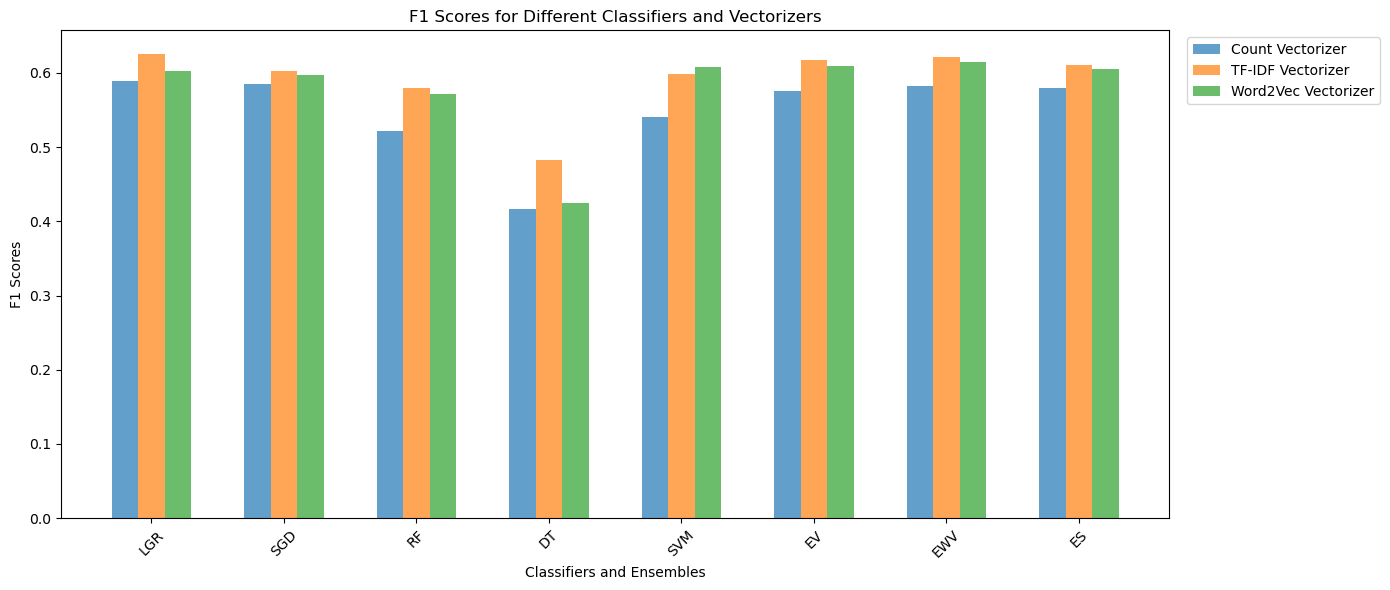

In [112]:
# This code generates a grouped bar chart using matplotlib to visualize the F1 score 
# of a set of classifiers (both base models and ensemble classifiers) across three different text vectorization 
# techniques (Count Vectorizer, TF-IDF Vectorizer, Word2Vec Vectorizer). The chart helps compare and visualize how these 
# classifiers (logistic regression-LGR, STOCHASTIC GRADIENT DESCENT (SGD), RANDOM FOREST(RF), DECISION TREE(DT), 
# SUPPORT VECTOR MACHINE(SVM), ENSEMBLE VOTING(EV), ENSEMBLE WEIGHTED VOTING(EWV), ENSEMBLE STACKING (ES), 
# perform under different vectorization methods.


# Define the classifiers and their F1 score for each vectorizer
classifiers = ["LGR", "SGD", "RF", "DT", "SVM", "EV", "EWV","ES"]
count_F1 = [0.589, 0.585, 0.521, 0.416, 0.541, 0.575, 0.582, 0.580]    # F1 score for count vectorizer
tfidf_F1 = [0.626, 0.602, 0.579, 0.483, 0.598, 0.617, 0.621, 0.610]     # F1 score for TF-IDF vectorizer
word2vec_F1 = [0.602, 0.597, 0.572, 0.424, 0.608, 0.609, 0.614, 0.605]   # F1 score for Word2Vec vectorizer

# Set the width of each bar in the bar chart
bar_width = 0.2

# Calculate the x-axis positions for each group of bars
index = np.arange(len(classifiers))  # Create an array of indices for the classifiers/ensembles

# Create the grouped bar chart
plt.figure(figsize=(14, 6))  # Create a figure object with a specific size for the plot
# Create bars for Count Vectorizer
plt.bar(index - bar_width, count_F1, bar_width, label='Count Vectorizer', alpha=0.7)
# Create bars for TF-IDF Vectorizer
plt.bar(index, tfidf_F1, bar_width, label='TF-IDF Vectorizer', alpha=0.7)
# Create bars for Word2Vec Vectorizer
plt.bar(index + bar_width, word2vec_F1, bar_width, label='Word2Vec Vectorizer', alpha=0.7)

# Set labels, title, and legend for the plot
plt.xlabel('Classifiers and Ensembles')  # Set the x-axis label
plt.ylabel('F1 Scores')  # Set the y-axis label
plt.title('F1 Scores for Different Classifiers and Vectorizers')  # Set the plot title
plt.xticks(index, classifiers, rotation=45)  # Set the x-axis labels and rotate them for readability

# set and Move the legend outside the chart
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust the layout for better display
plt.show()  # Show the plot on the screen

#### Observing the F1 bar graph above, it's evident that among the base classifiers, Logistic Regression (LGR) achieves the highest F1 Scores in both Count and TF-IDF vectorizers. However, in the Word2Vec vectorizer, Support Vector Machine (SVM) leads the way. Conversely, Decision Tree (DT) consistently falls behind in this category across all vectorizers. When it comes to Ensemble classifiers, Ensemble Weighted Voting (EWV) outperforms all other ensembles across all three vectorizers.

### Average recall comparison of Base and Ensemble Classifiers

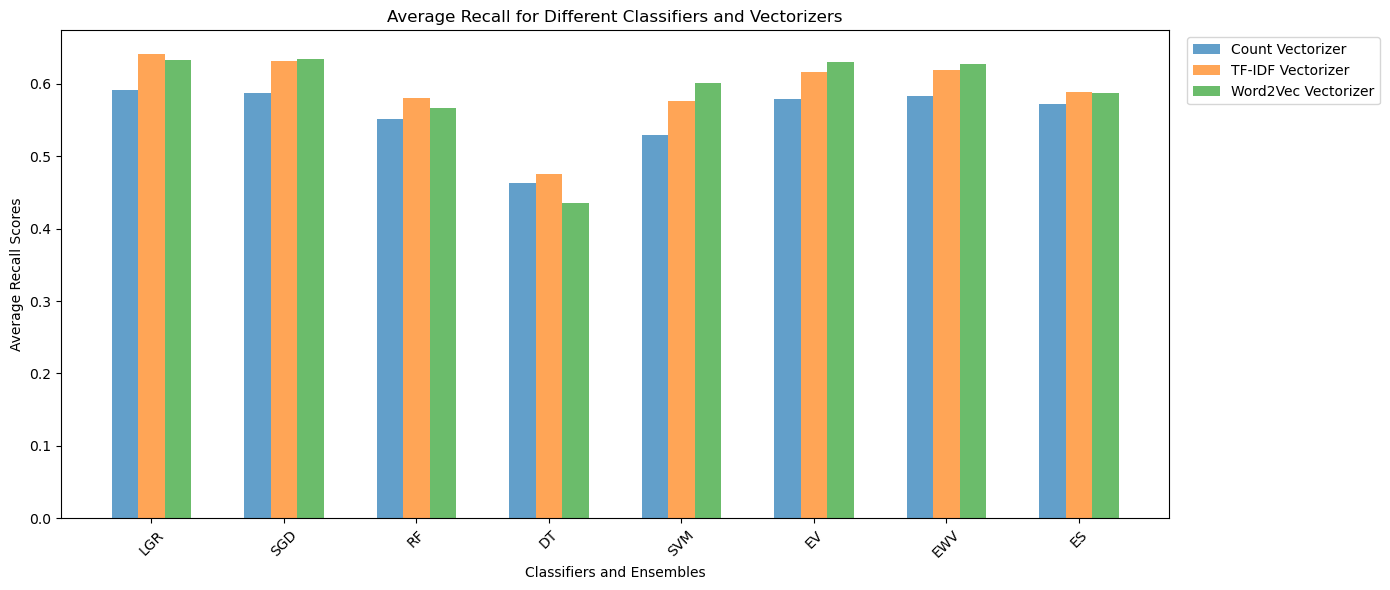

In [113]:
# This code generates a grouped bar chart using matplotlib to visualize the Average Recall 
# of a set of classifiers (both base models and ensemble classifiers) across three different text vectorization 
# techniques (Count Vectorizer, TF-IDF Vectorizer, Word2Vec Vectorizer). The chart helps compare and visualize how these 
# classifiers (logistic regression-LGR, STOCHASTIC GRADIENT DESCENT (SGD), RANDOM FOREST(RF), DECISION TREE(DT), 
# SUPPORT VECTOR MACHINE(SVM), ENSEMBLE VOTING(EV), ENSEMBLE WEIGHTED VOTING(EWV), ENSEMBLE STACKING (ES), 
# perform under different vectorization methods.


# Define the classifiers and their Average Recall for each vectorizer
classifiers = ["LGR", "SGD", "RF", "DT", "SVM", "EV", "EWV","ES"]
count_AR = [0.591, 0.587, 0.552, 0.463, 0.530, 0.579, 0.583, 0.573]    # Average Recall for count vectorizer
tfidf_AR = [0.642, 0.632, 0.581, 0.475, 0.576, 0.616, 0.619, 0.589]     # Average Recall for TF-IDF vectorizer
word2vec_AR = [0.633, 0.634, 0.567, 0.436, 0.601, 0.630, 0.627, 0.588]   # Average Recall for Word2Vec vectorizer

# Set the width of each bar in the bar chart
bar_width = 0.2

# Calculate the x-axis positions for each group of bars
index = np.arange(len(classifiers))  # Create an array of indices for the classifiers/ensembles

# Create the grouped bar chart
plt.figure(figsize=(14, 6))  # Create a figure object with a specific size for the plot
# Create bars for Count Vectorizer
plt.bar(index - bar_width, count_AR, bar_width, label='Count Vectorizer', alpha=0.7)
# Create bars for TF-IDF Vectorizer
plt.bar(index, tfidf_AR, bar_width, label='TF-IDF Vectorizer', alpha=0.7)
# Create bars for Word2Vec Vectorizer
plt.bar(index + bar_width, word2vec_AR, bar_width, label='Word2Vec Vectorizer', alpha=0.7)

# Set labels, title, and legend for the plot
plt.xlabel('Classifiers and Ensembles')  # Set the x-axis label
plt.ylabel('Average Recall Scores')  # Set the y-axis label
plt.title('Average Recall for Different Classifiers and Vectorizers')  # Set the plot title
plt.xticks(index, classifiers, rotation=45)  # Set the x-axis labels and rotate them for readability

# set and Move the legend outside the chart
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust the layout for better display
plt.show()  # Show the plot on the screen

#### Analyzing the Average Recall bar graph above, it's evident that among the base classifiers, Logistic Regression (LGR) showcases the highest average recall across both count and TF-IDF vectorizers. However, in the Word2Vec vectorizer, Stochastic Gradient Descent (SGD) takes the lead. Conversely, Decision Tree consistently lags behind in this category across all vectorizers. When it comes to Ensemble classifiers, Ensemble Weighted Voting (EWV) outperformed others in both the count and TF-IDF vectorizers. However, Ensemble Voting (EV) emerged as the top performer in the Word2Vec vectorizer.

# Evaluation of Ensemble Models on Unseen SemEval Test Dataset

### The organizers of the SemEval 2017 subtask 4A provided a distinct and previously unobserved text dataset for evaluating the effectiveness of our models. We assessed the performance of our various ensemble models using this test dataset.

### Performance of Bag-of-Words Ensemble Models on SemEval Test Data

Ensemble Voting Classifier Accuracy: 0.404
Ensemble Voting Classifier f1_score: 0.388
Ensemble Voting Classifier average_recall: 0.443
Ensemble Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.35      0.82      0.49      3811
           0       0.53      0.14      0.22      5743
           1       0.57      0.37      0.45      2352

    accuracy                           0.40     11906
   macro avg       0.48      0.44      0.39     11906
weighted avg       0.48      0.40      0.35     11906

------------------------------------


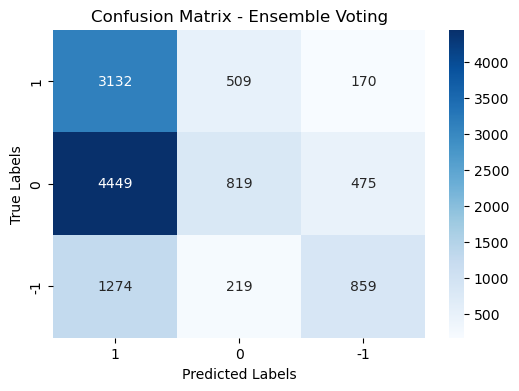

Analysing Classification Errors in:ENSEMBLE VOTING
1 classified as 0: 509 times
1 classified as -1: 170 times
0 classified as 1: 4449 times
0 classified as -1: 475 times
-1 classified as 1: 1274 times
-1 classified as 0: 219 times

Weighted Majority Voting Classifier Accuracy: 0.406
Weighted Majority Voting Classifier f1_score: 0.391
Weighted Majority Voting Classifier average_recall: 0.447
Weighted Majority Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.36      0.82      0.50      3811
           0       0.53      0.14      0.23      5743
           1       0.55      0.38      0.45      2352

    accuracy                           0.41     11906
   macro avg       0.48      0.45      0.39     11906
weighted avg       0.48      0.41      0.36     11906

------------------------------------


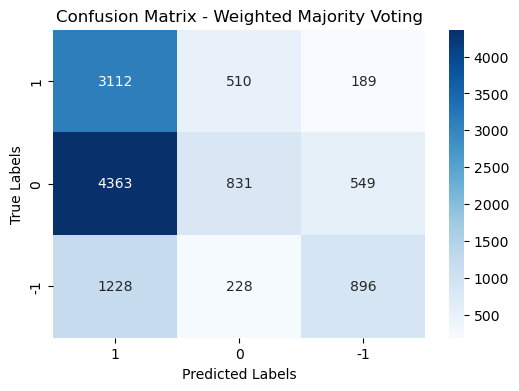

Analysing Classification Errors in:WEIGHTED MAJORITY VOTING
1 classified as 0: 510 times
1 classified as -1: 189 times
0 classified as 1: 4363 times
0 classified as -1: 549 times
-1 classified as 1: 1228 times
-1 classified as 0: 228 times

Ensemble Stacking Classifier Accuracy: 0.437
Ensemble Stacking Classifier f1_score: 0.441
Ensemble Stacking Classifier average_recall: 0.482
Ensemble Stacking Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.39      0.67      0.49      3811
           0       0.53      0.24      0.33      5743
           1       0.46      0.53      0.49      2352

    accuracy                           0.44     11906
   macro avg       0.46      0.48      0.44     11906
weighted avg       0.47      0.44      0.42     11906

------------------------------------


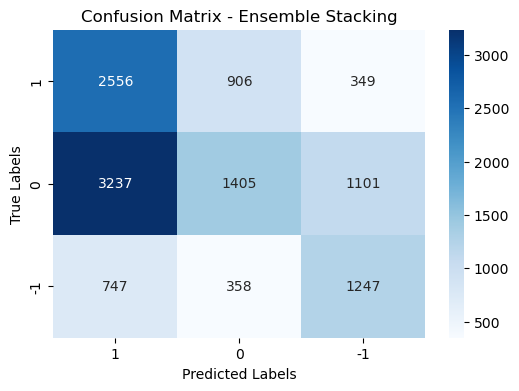

Analysing Classification Errors in:ENSEMBLE STACKING
1 classified as 0: 906 times
1 classified as -1: 349 times
0 classified as 1: 3237 times
0 classified as -1: 1101 times
-1 classified as 1: 747 times
-1 classified as 0: 358 times



In [103]:
# Call the function 'train_ensemble' to train and evaluate the ensemble classifiers on the final test data.
# The function will return the evaluation results and confusion matrices for each ensemble classifier.
count_ensemble_results, ensemble_confusion_matrices = ensemble_classification(
    ensemble_classifiers,              # Dictionary of ensemble classifiers
    count_train_oversampled,           # Training data (oversampled) for the ensemble classifiers
    count_labels_oversampled,          # Labels for the oversampled training data
    count_test_data,                   # test data for evaluation
    testing_labels,                    # True labels for the test data
    class_labels=[1, 0, -1]            # Class labels for plotting the confusion matrices
)

### Performance of TF-IDF Ensemble Models on SemEval Test Data

Ensemble Voting Classifier Accuracy: 0.577
Ensemble Voting Classifier f1_score: 0.524
Ensemble Voting Classifier average_recall: 0.511
Ensemble Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.61      0.33      0.43      3811
           0       0.56      0.82      0.66      5743
           1       0.64      0.38      0.48      2352

    accuracy                           0.58     11906
   macro avg       0.60      0.51      0.52     11906
weighted avg       0.59      0.58      0.55     11906

------------------------------------


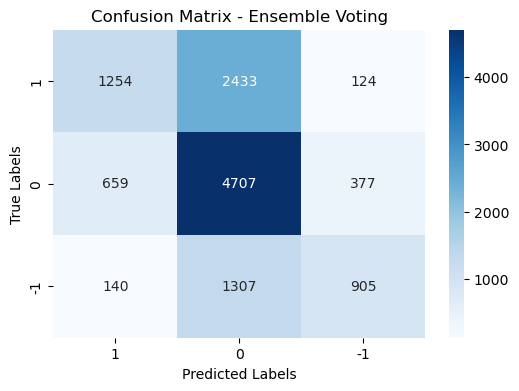

Analysing Classification Errors in:ENSEMBLE VOTING
1 classified as 0: 2433 times
1 classified as -1: 124 times
0 classified as 1: 659 times
0 classified as -1: 377 times
-1 classified as 1: 140 times
-1 classified as 0: 1307 times

Weighted Majority Voting Classifier Accuracy: 0.578
Weighted Majority Voting Classifier f1_score: 0.525
Weighted Majority Voting Classifier average_recall: 0.514
Weighted Majority Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.64      0.32      0.42      3811
           0       0.56      0.82      0.67      5743
           1       0.61      0.40      0.48      2352

    accuracy                           0.58     11906
   macro avg       0.60      0.51      0.52     11906
weighted avg       0.59      0.58      0.55     11906

------------------------------------


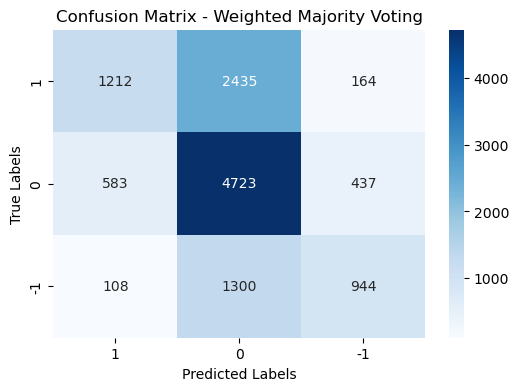

Analysing Classification Errors in:WEIGHTED MAJORITY VOTING
1 classified as 0: 2435 times
1 classified as -1: 164 times
0 classified as 1: 583 times
0 classified as -1: 437 times
-1 classified as 1: 108 times
-1 classified as 0: 1300 times

Ensemble Stacking Classifier Accuracy: 0.566
Ensemble Stacking Classifier f1_score: 0.507
Ensemble Stacking Classifier average_recall: 0.503
Ensemble Stacking Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.64      0.25      0.36      3811
           0       0.55      0.83      0.66      5743
           1       0.60      0.42      0.50      2352

    accuracy                           0.57     11906
   macro avg       0.60      0.50      0.51     11906
weighted avg       0.59      0.57      0.53     11906

------------------------------------


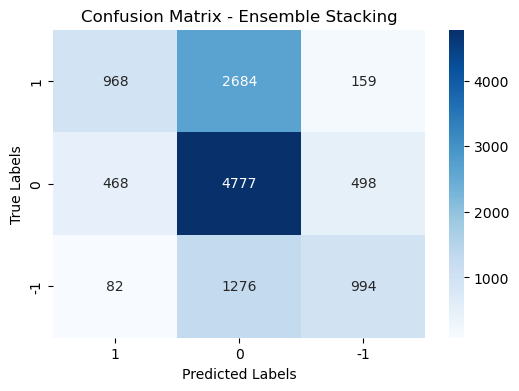

Analysing Classification Errors in:ENSEMBLE STACKING
1 classified as 0: 2684 times
1 classified as -1: 159 times
0 classified as 1: 468 times
0 classified as -1: 498 times
-1 classified as 1: 82 times
-1 classified as 0: 1276 times



In [104]:
# Call the function 'train_ensemble' to train and evaluate the ensemble classifiers on the Final test data.
# The function will return the evaluation results and confusion matrices for each ensemble classifier.
tfidf_ensemble_results, ensemble_confusion_matrices = ensemble_classification(
    ensemble_classifiers,        # Dictionary of ensemble classifiers
    tfidf_train_oversampled,     # Training data (oversampled) for the ensemble classifiers
    tfidf_labels_oversampled,    # Labels for the oversampled training data
    tfidf_test_data,             # test data for evaluation
    testing_labels,              # True labels for the test data
    class_labels=[1, 0, -1]      # Class labels for plotting the confusion matrices
)

### Word2Vec Ensemble Models Performance on the SemEval Test Data

Ensemble Voting Classifier Accuracy: 0.611
Ensemble Voting Classifier f1_score: 0.597
Ensemble Voting Classifier average_recall: 0.590
Ensemble Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.58      0.69      0.63      3811
           0       0.63      0.62      0.63      5743
           1       0.64      0.46      0.54      2352

    accuracy                           0.61     11906
   macro avg       0.62      0.59      0.60     11906
weighted avg       0.62      0.61      0.61     11906

------------------------------------


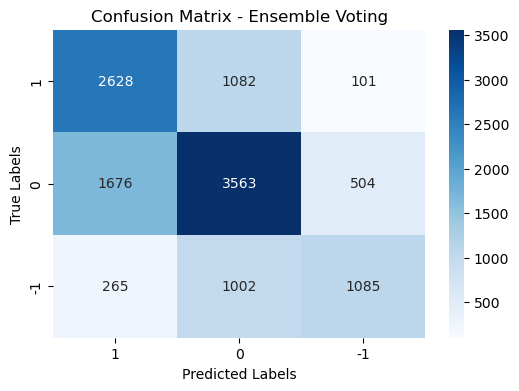

Analysing Classification Errors in:ENSEMBLE VOTING
1 classified as 0: 1082 times
1 classified as -1: 101 times
0 classified as 1: 1676 times
0 classified as -1: 504 times
-1 classified as 1: 265 times
-1 classified as 0: 1002 times

Weighted Majority Voting Classifier Accuracy: 0.615
Weighted Majority Voting Classifier f1_score: 0.599
Weighted Majority Voting Classifier average_recall: 0.588
Weighted Majority Voting Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.61      0.61      0.61      3811
           0       0.62      0.67      0.64      5743
           1       0.63      0.48      0.54      2352

    accuracy                           0.62     11906
   macro avg       0.62      0.59      0.60     11906
weighted avg       0.62      0.62      0.61     11906

------------------------------------


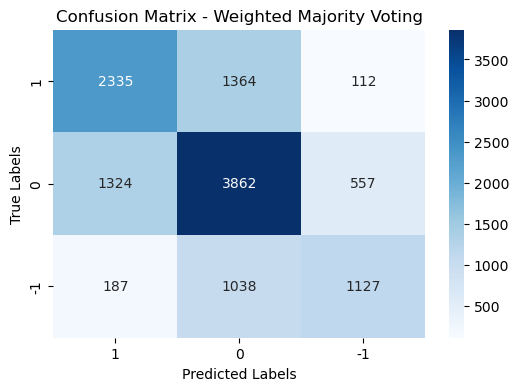

Analysing Classification Errors in:WEIGHTED MAJORITY VOTING
1 classified as 0: 1364 times
1 classified as -1: 112 times
0 classified as 1: 1324 times
0 classified as -1: 557 times
-1 classified as 1: 187 times
-1 classified as 0: 1038 times

Ensemble Stacking Classifier Accuracy: 0.586
Ensemble Stacking Classifier f1_score: 0.516
Ensemble Stacking Classifier average_recall: 0.505
Ensemble Stacking Classifier Classification Report:
              precision    recall  f1-score   support

          -1       0.72      0.29      0.42      3811
           0       0.55      0.88      0.68      5743
           1       0.68      0.34      0.45      2352

    accuracy                           0.59     11906
   macro avg       0.65      0.51      0.52     11906
weighted avg       0.63      0.59      0.55     11906

------------------------------------


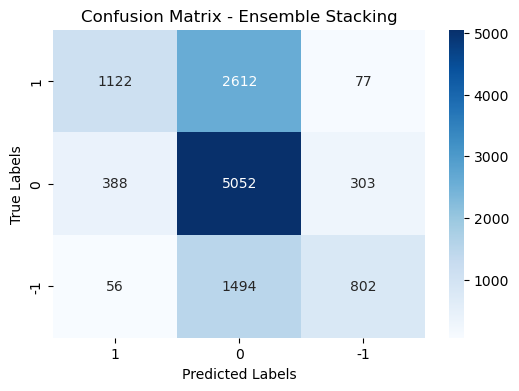

Analysing Classification Errors in:ENSEMBLE STACKING
1 classified as 0: 2612 times
1 classified as -1: 77 times
0 classified as 1: 388 times
0 classified as -1: 303 times
-1 classified as 1: 56 times
-1 classified as 0: 1494 times



In [105]:
# Call the function 'train_ensemble' to train and evaluate the ensemble classifiers on the final test data.
# The function will return the evaluation results and confusion matrices for each ensemble classifier.
final_w2v_ensemble_results = ensemble_classification(
    ensemble_classifiers,        # Dictionary of ensemble classifiers
    w2v_train_oversampled,       # Training data (oversampled) for the ensemble classifiers
    w2v_labels_oversampled,      # Labels for the oversampled training data
    w2v_test_data,               # test data for evaluation
    testing_labels,              # True labels for the test data
    class_labels=[1, 0, -1]      # Class labels for plotting the confusion matrices
)

### Among the three models, it was the Word2Vec with Weighted Majority Voting that emerged as the top performer on the SemEval test dataset. This model showcased remarkable achievements, boasting the highest accuracy score of 0.615, the highest F1 score reaching 0.599, and maintaining a competitive average recall of 0.588. While the TF-IDF with Ensemble Stacking had initially demonstrated superior accuracy throughout our development phase, the Word2Vec with Weighted Majority Voting, demonstrated its prowess in the ultimate evaluation. This paradigm shift in performance underscores the dynamic nature of machine learning models and the importance of assessing their performance under real-world test conditions.